In [14]:
!pip install dionysus
!pip install zarr
!pip install POT
!pip install gudhi
!pip install validclust

In [15]:
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive',force_remount=True)
#os.chdir("/content/drive/My Drive/Data 6.5")
os.chdir("/content/drive/My Drive/NASA/Fire Detection/Data 6.5")
!ls -ltr

Mounted at /content/drive
total 12815
-rw------- 1 root root 13118050 May  2 07:17 Fire_Labels_2020-2021.csv
drwx------ 2 root root     4096 May 30 04:41 Tiles_2021_2022


In [16]:
import zarr
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import dionysus as d
import matplotlib.pyplot as plt
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance as wd
from gudhi.representations import Landscape
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from validclust import dunn, cop, ValidClust
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import gudhi
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
sns.set_theme()

In [17]:
fname2 = 'Tiles_2021_2022'
rawFileList = os.listdir(fname2)
print (rawFileList)
print (len(rawFileList))

['Tile_1_33_20213570001178.zarr', 'Tile_1_33_20213600001178.zarr', 'Tile_1_33_20213640001178.zarr', 'Tile_1_33_20213630001178.zarr', 'Tile_1_33_20213550001178.zarr', 'Tile_1_33_20213610001178.zarr', 'Tile_1_33_20213620001178.zarr', 'Tile_1_33_20213590001178.zarr', 'Tile_1_33_20213560001178.zarr', 'Tile_1_33_20213580001178.zarr', 'Tile_1_33_20213540001178.zarr', 'Tile_1_33_20213450001177.zarr', 'Tile_1_33_20213470001177.zarr', 'Tile_1_33_20213460001177.zarr', 'Tile_1_33_20213480001178.zarr', 'Tile_1_33_20213490001178.zarr', 'Tile_1_33_20213520001178.zarr', 'Tile_1_33_20213510001178.zarr', 'Tile_1_33_20213500001178.zarr', 'Tile_1_33_20213530001178.zarr', 'Tile_1_33_20213400001177.zarr', 'Tile_1_33_20213410001177.zarr', 'Tile_1_33_20213440001177.zarr', 'Tile_1_33_20213350001177.zarr', 'Tile_1_33_20213420001177.zarr', 'Tile_1_33_20213390001177.zarr', 'Tile_1_33_20213430001177.zarr', 'Tile_1_33_20213380001177.zarr', 'Tile_1_33_20213360001177.zarr', 'Tile_1_33_20213370001177.zarr', 'Tile_1_3

In [18]:
#fname2 = 'Tiles'
csvName = 'Fire_Labels_2020-2021.csv'
#csvName2 = 'Fire_Labels_2020-2021.csv'
dfLabel = pd.read_csv(csvName)[['fname', 'fire']]
#dfLabel2 = pd.read_csv(csvName2)[['fname', 'fire']]

#rawFileList = dfLabel['fname'].tolist()
#fireDays = dfLabel.loc[dfLabel['fire'] == 1, 'fname'].tolist()
#print (fireDays)

#noFireDays = dfLabel.loc[dfLabel['fire'] == 0, 'fname'].tolist()

#print (len(fireDays) + len(noFireDays))

label = dfLabel.loc[dfLabel['fname'] == 'Tile_1_33_20203370001177.zarr', 'fire'].iloc[0]
print (label)

0


In [19]:
fire_name_list = dfLabel.loc[dfLabel['fire'] == 1, 'fname'].tolist()
print (len(fire_name_list))
print (fire_name_list)

1823
['Tile_1_33_20213050001176.zarr', 'Tile_1_33_20213050011176.zarr', 'Tile_1_33_20213050016176.zarr', 'Tile_1_33_20213050021176.zarr', 'Tile_1_33_20213050026176.zarr', 'Tile_1_33_20213050031176.zarr', 'Tile_1_33_20213050041176.zarr', 'Tile_1_33_20213050051176.zarr', 'Tile_1_33_20213050056176.zarr', 'Tile_1_33_20213050101176.zarr', 'Tile_1_33_20213050106176.zarr', 'Tile_1_33_20213050116176.zarr', 'Tile_1_33_20213050121176.zarr', 'Tile_1_33_20213050126176.zarr', 'Tile_1_33_20213050131176.zarr', 'Tile_1_33_20213050136176.zarr', 'Tile_1_33_20213050141176.zarr', 'Tile_1_33_20213050146176.zarr', 'Tile_1_33_20213050151176.zarr', 'Tile_1_33_20213050156176.zarr', 'Tile_1_33_20213050201176.zarr', 'Tile_1_33_20213050206176.zarr', 'Tile_1_33_20213050211176.zarr', 'Tile_1_33_20213050216176.zarr', 'Tile_1_33_20213050221176.zarr', 'Tile_1_33_20213050226177.zarr', 'Tile_1_33_20213050236177.zarr', 'Tile_1_33_20213050241177.zarr', 'Tile_1_33_20213051746176.zarr', 'Tile_1_33_20213051751176.zarr', 'Til

In [20]:
print (len(rawFileList))

425


In [21]:
channel7List = []
channel7Name = []
timeSeriesDict = {}

for name in rawFileList:
    channelData = np.array(zarr.open(fname2 + '//' + name)[:, :, 0]) # select channel 7
    timeSeriesDict[name] = channelData
    channel7List.append(channelData)
    channel7Name.append(name)

print (len(channel7List))

425


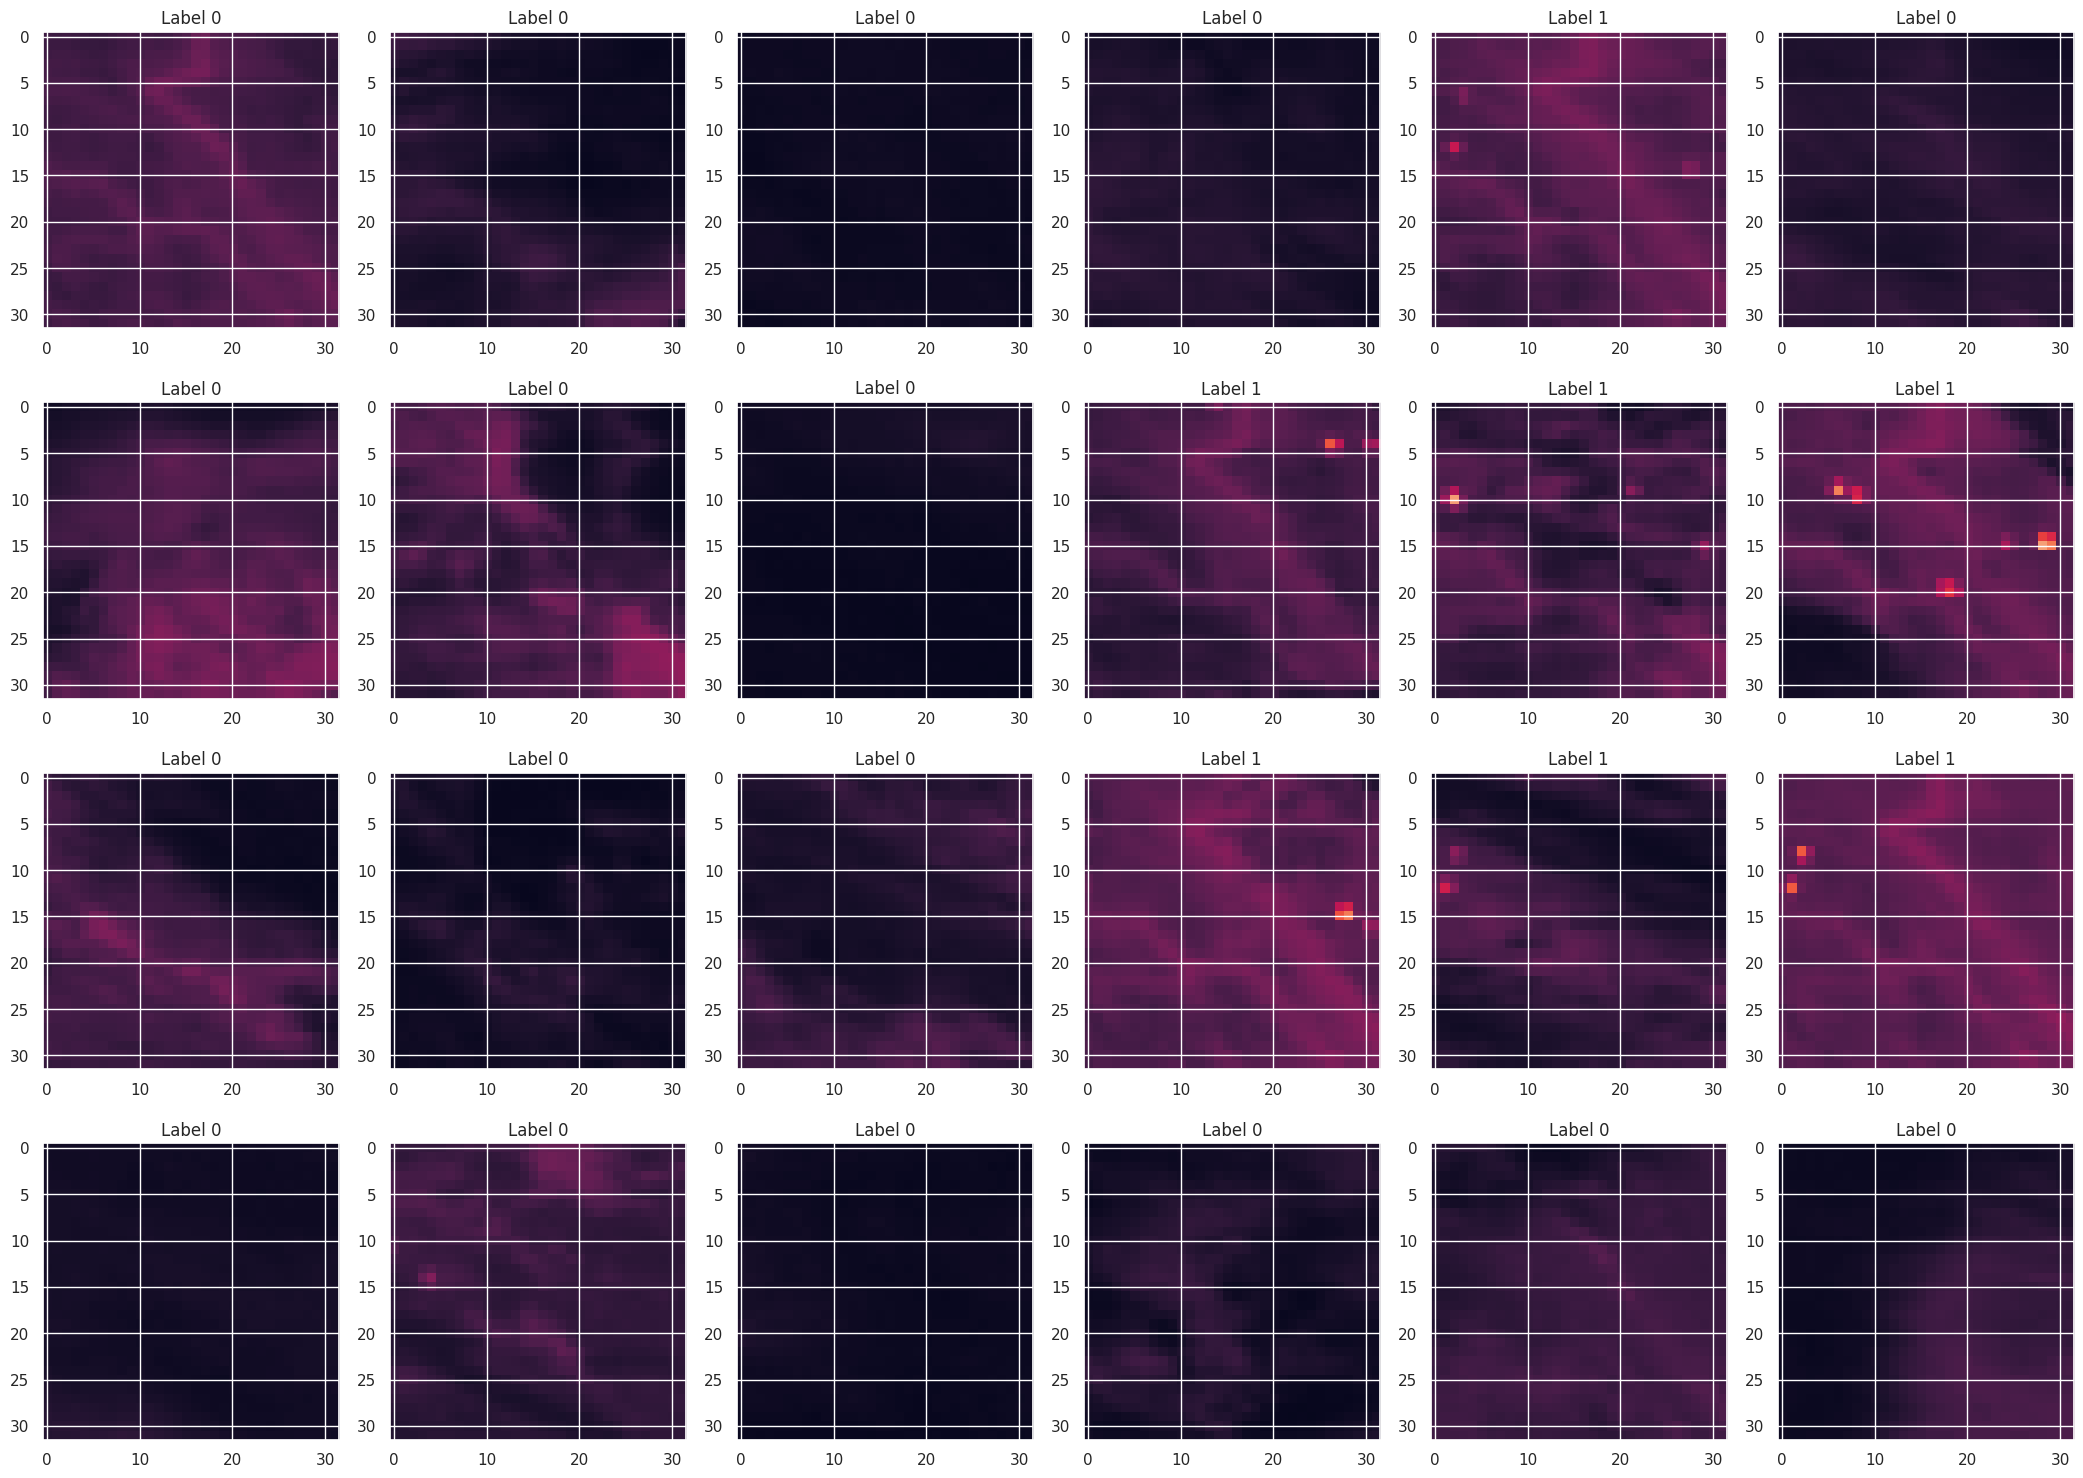

In [22]:
# plot channel 7 timeseries
fig, axs = plt.subplots(4, 6, figsize=(21, 15))

for i in range(4):
    for j in range(6):
        axs[i, j].imshow(channel7List[i* 6 + j + 40], vmin=0, vmax=1) # vmin, vmax may change on different tiles
        label = dfLabel.loc[dfLabel['fname'] == channel7Name[i* 6 + j + 40], 'fire'].iloc[0]
        axs[i, j].title.set_text('Label {}'.format(label))

plt.tight_layout()

In [23]:
def extract_PD_arrays_with_freudenthal_triangulation(data, lower_bound = 0, upper_bound = 8): #change upper bound!!!!!!!!!!

    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = upper_bound
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = upper_bound

    return [[birth0,death0],[birth1,death1]]

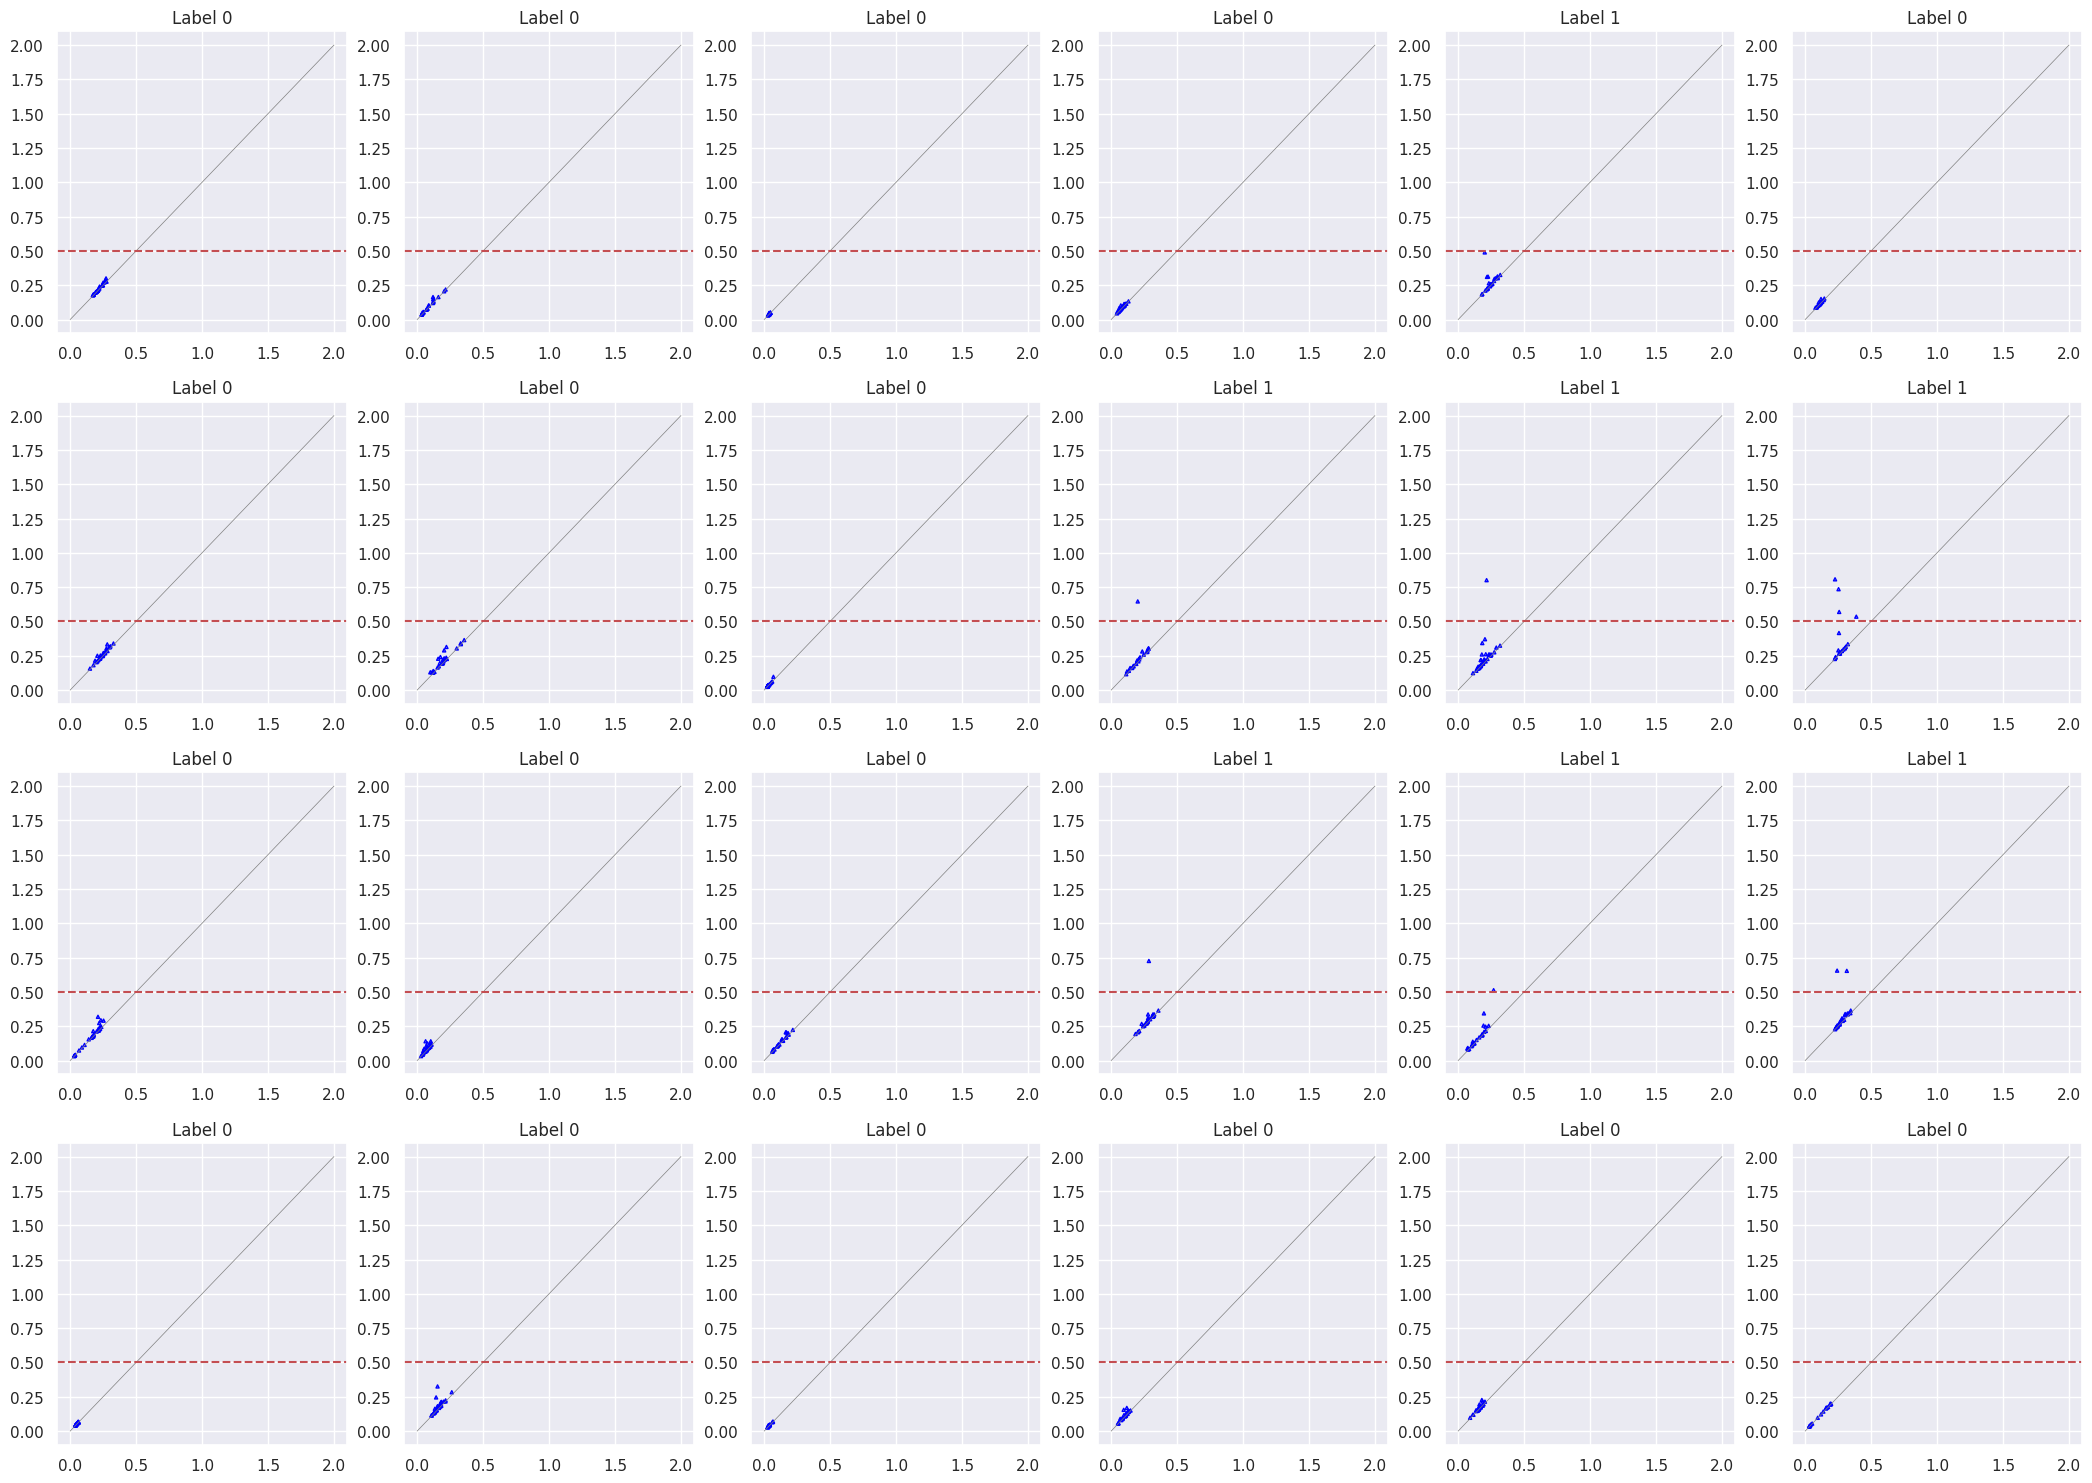

In [24]:
fig, axs = plt.subplots(4, 6, figsize=(21, 15))

pd0_union = []
pd1_union = []
groundTruth = []
for i in range(4):
    for j in range(6):
        lower_bound = 0
        upper_bound = 3

        p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(channel7List[i* 6 + j + 40], lower_bound = lower_bound, upper_bound = upper_bound)
        pd0_union.append(p0)
        pd1_union.append(p1)
        #axs[i, j].scatter(birth0, death0, color='r', s=5, label = 'Dimension 0')
        axs[i, j].scatter(p1[0], p1[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
        #axs[i, j].scatter(p0[0], p0[1], marker='^', s=5, facecolors='none', edgecolor='red', label = 'Dimension 0')
        axs[i, j].plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        #axs[i, j].plot(np.arange(lower_bound, upper_bound), 2, '-', color='grey', lw=0.5)
        axs[i, j].axhline(y = 0.5, color='r', linestyle='--')

        label = dfLabel.loc[dfLabel['fname'] == channel7Name[i* 6 + j + 40], 'fire'].iloc[0]
        groundTruth.append(label)
        axs[i, j].title.set_text('Label {}'.format(label))
        #axs[i, j].set_xlabel('Birth')
        #axs[i, j].set_ylabel('Death')

plt.tight_layout()
plt.show()

In [25]:
def optimalDBSCAN(data, score_, eps, metric='euclidean', bMax=True, distType=0):
    eps_range=np.arange(eps['min'],eps['max'],eps['inc'])
    min_samples_range=range(2,10)
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9

    eps_ask=0
    min_samples_ask=0
    clustering_ask=None
    print("score, best_score, eps, eps_ask, min_samples, min_samples_ask")
    for min_samples in min_samples_range:
     for eps in eps_range:
      clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
      clustering.fit(data)
      if len(np.unique(clustering.labels_))>1:
        if distType==0:
            score=score_(data, clustering.labels_)
        elif distType==1:
            dist=pairwise_distances(data)
            score=score_(dist, clustering.labels_)
        elif distType==2:
            dist=pairwise_distances(data)
            score=score_(data, dist, clustering.labels_)
        if (score>best_score and bMax==True):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering
        elif(score<best_score and bMax==False):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering
        print(score, best_score, eps, eps_ask, min_samples, min_samples_ask)
    return(best_score, eps_ask, min_samples_ask, clustering_ask)

def optimalHClust(data, score_, metric='euclidean', bMax=True, distType=0):
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
    linkage_ask = ''
    n_ask = 2
    clustering_ask = None
    print("score, best_score, i, n_ask, linkage, linkage_ask")
    for i in range(2, 7):
        for linkage in ['complete', 'average', 'single']:
            clustering= AgglomerativeClustering(n_clusters=i, affinity=metric, linkage=linkage)
            #clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            clustering.fit(data)
            if len(np.unique(clustering.labels_))>1:
                if distType==0:
                    score=score_(data, clustering.labels_)
                elif distType==1:
                    dist=pairwise_distances(data)
                    score=score_(dist, clustering.labels_)
                elif distType==2:
                    dist=pairwise_distances(data)
                    score=score_(data, dist, clustering.labels_)
                if (score>best_score and bMax==True):
                    best_score=score
                    linkage_ask=linkage
                    n_ask=i
                    clustering_ask=clustering
                elif(score<best_score and bMax==False):
                    best_score=score
                    linkage_ask=linkage
                    n_ask=i
                    clustering_ask=clustering
                print(score, best_score, i, n_ask, linkage, linkage_ask)
    return(best_score, n_ask, linkage_ask, clustering_ask)

In [26]:
def PD2Silhoutte(PDList, resolution = 100):
    SH = gd.representations.Silhouette(resolution=resolution, weight=lambda x: np.power(x[1]-x[0],1))
    SilList = []
    for i in range(len(PDList)):
        sh = SH.fit_transform([PDList[i]])[0]
        SilList.append(sh)
    return SilList

In [27]:
PDList = []
for i in pd1_union:
    temp = np.vstack((i[0], i[1])).T
    PDList.append(temp)

In [28]:
print (PDList[0])

[[0.17202304 0.17671609]
 [0.17515175 0.17828044]
 [0.17671609 0.18453784]
 [0.17828044 0.18140915]
 [0.17828044 0.1798448 ]
 [0.19235961 0.1954883 ]
 [0.19392395 0.20018137]
 [0.20018137 0.20487441]
 [0.20018137 0.20174572]
 [0.20174572 0.20331006]
 [0.20800312 0.21113181]
 [0.20956747 0.21113181]
 [0.20956747 0.21113181]
 [0.21426053 0.21582486]
 [0.21895356 0.23146839]
 [0.22051792 0.22521098]
 [0.22364663 0.24085449]
 [0.24241884 0.24867626]
 [0.24398319 0.24867626]
 [0.24398319 0.25024056]
 [0.24867626 0.25024056]
 [0.25024056 0.26901278]
 [0.25962669 0.27057713]
 [0.26901278 0.28934935]
 [0.26901278 0.2783989 ]
 [0.27214149 0.30029982]
 [0.27214149 0.27683455]
 [0.27527019 0.27683455]]


DDALPHA

In [ ]:
os.chdir("/content/drive/My Drive/")
!ls -ltr

total 1110387
-rw------- 1 root root    696774 Aug 21  2017 'Getting started.pdf'
-rw------- 1 root root       174 Nov 10  2017 "Henry and Donald Visuals DOs and DON'Ts.gdoc"
-rw------- 1 root root  40841983 Nov 14  2017  common-questions-lqkxkbfrzdes.zip
drwx------ 2 root root      4096 Jan 26  2018  Henry_540_1
-rw------- 1 root root       174 Feb 28  2018 'Copy of 540_Final Exam_Practice_Part 2_GR.docx.gdoc'
drwx------ 2 root root      4096 Mar 26  2020  Classroom
-rw------- 1 root root   1342127 Mar 26  2020  IMG_2455.JPG
-rw------- 1 root root   1485082 Mar 26  2020  IMG_2454.JPG
-rw------- 1 root root   1599540 Mar 26  2020  IMG_2453.JPG
-rw------- 1 root root   1786323 Apr  6  2020  IMG_2495.JPG
-rw------- 1 root root   1515123 Apr  6  2020  IMG_2494.JPG
-rw------- 1 root root   1688604 Apr  6  2020  IMG_2493.JPG
-rw------- 1 root root   1480506 Apr  6  2020  IMG_2496.JPG
-rw------- 1 root root   1457692 May  2  2020  3.JPG
-rw------- 1 root root   1644152 May  2  2020 '1 (1).JP

In [ ]:
r = robjects.r
r['source']('vector_ddalpha_1.R')

(as ‘lib’ is unspecified)
































































	‘/tmp/RtmpREqrwF/downloaded_packages’








value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [ ]:
simplicial_volume = robjects.globalenv['simplicial_volume_list']
convex_hull_peeling = robjects.globalenv['convex_hull_peeling_list']
zoinoid = robjects.globalenv['zonoid_depth_list']
spatial = robjects.globalenv['spatial_depth_list']
mahalanobis = robjects.globalenv['mahalanobis_depth_list']
halfspace = robjects.globalenv['halfspace_depth_list']
projection = robjects.globalenv['projection_depth_list']
simplicial = robjects.globalenv['simplicial_depth_list']

In [ ]:
# Vectorize the PDs then do cluster
# Vectorize by Silhoutte
SilList = PD2Silhoutte(PDList, resolution=10)
#Pass silList to R
m = robjects.r['matrix'](SilList, nrow=24, ncol=10) #specify number of columns and rows

In [ ]:
# Simplicial Volume
temp_list = simplicial_volume(m)

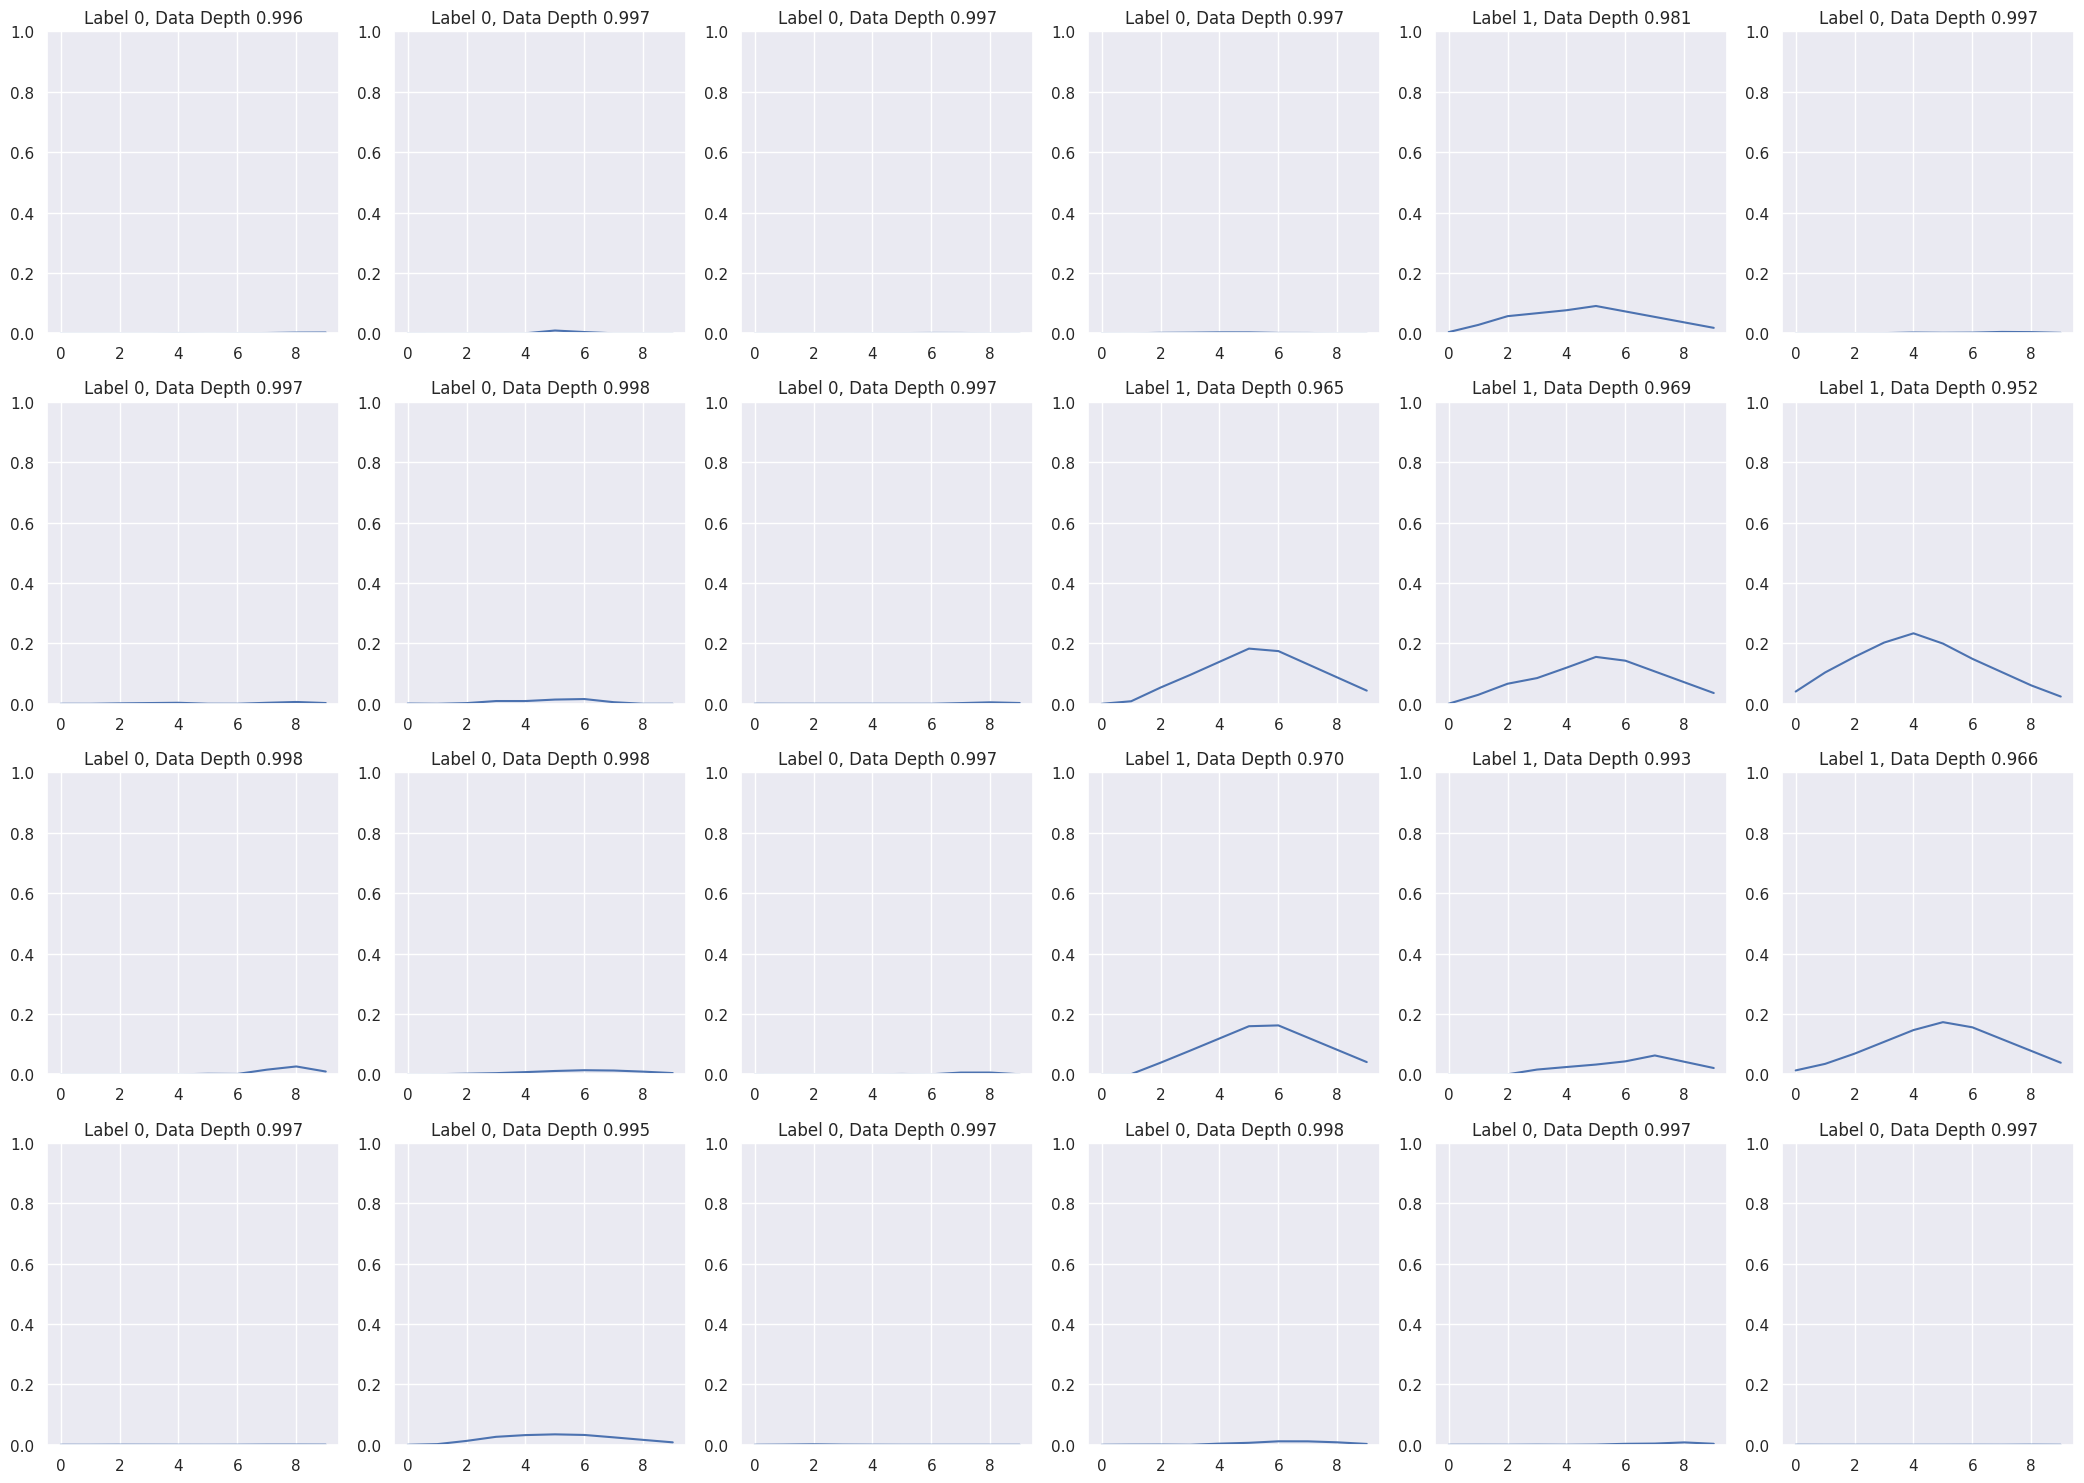

In [ ]:
list_r = []
for i in temp_list:
  list_r.append(i[0])
simplexVolDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], simplexVolDepthList[i*6 + j]))

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

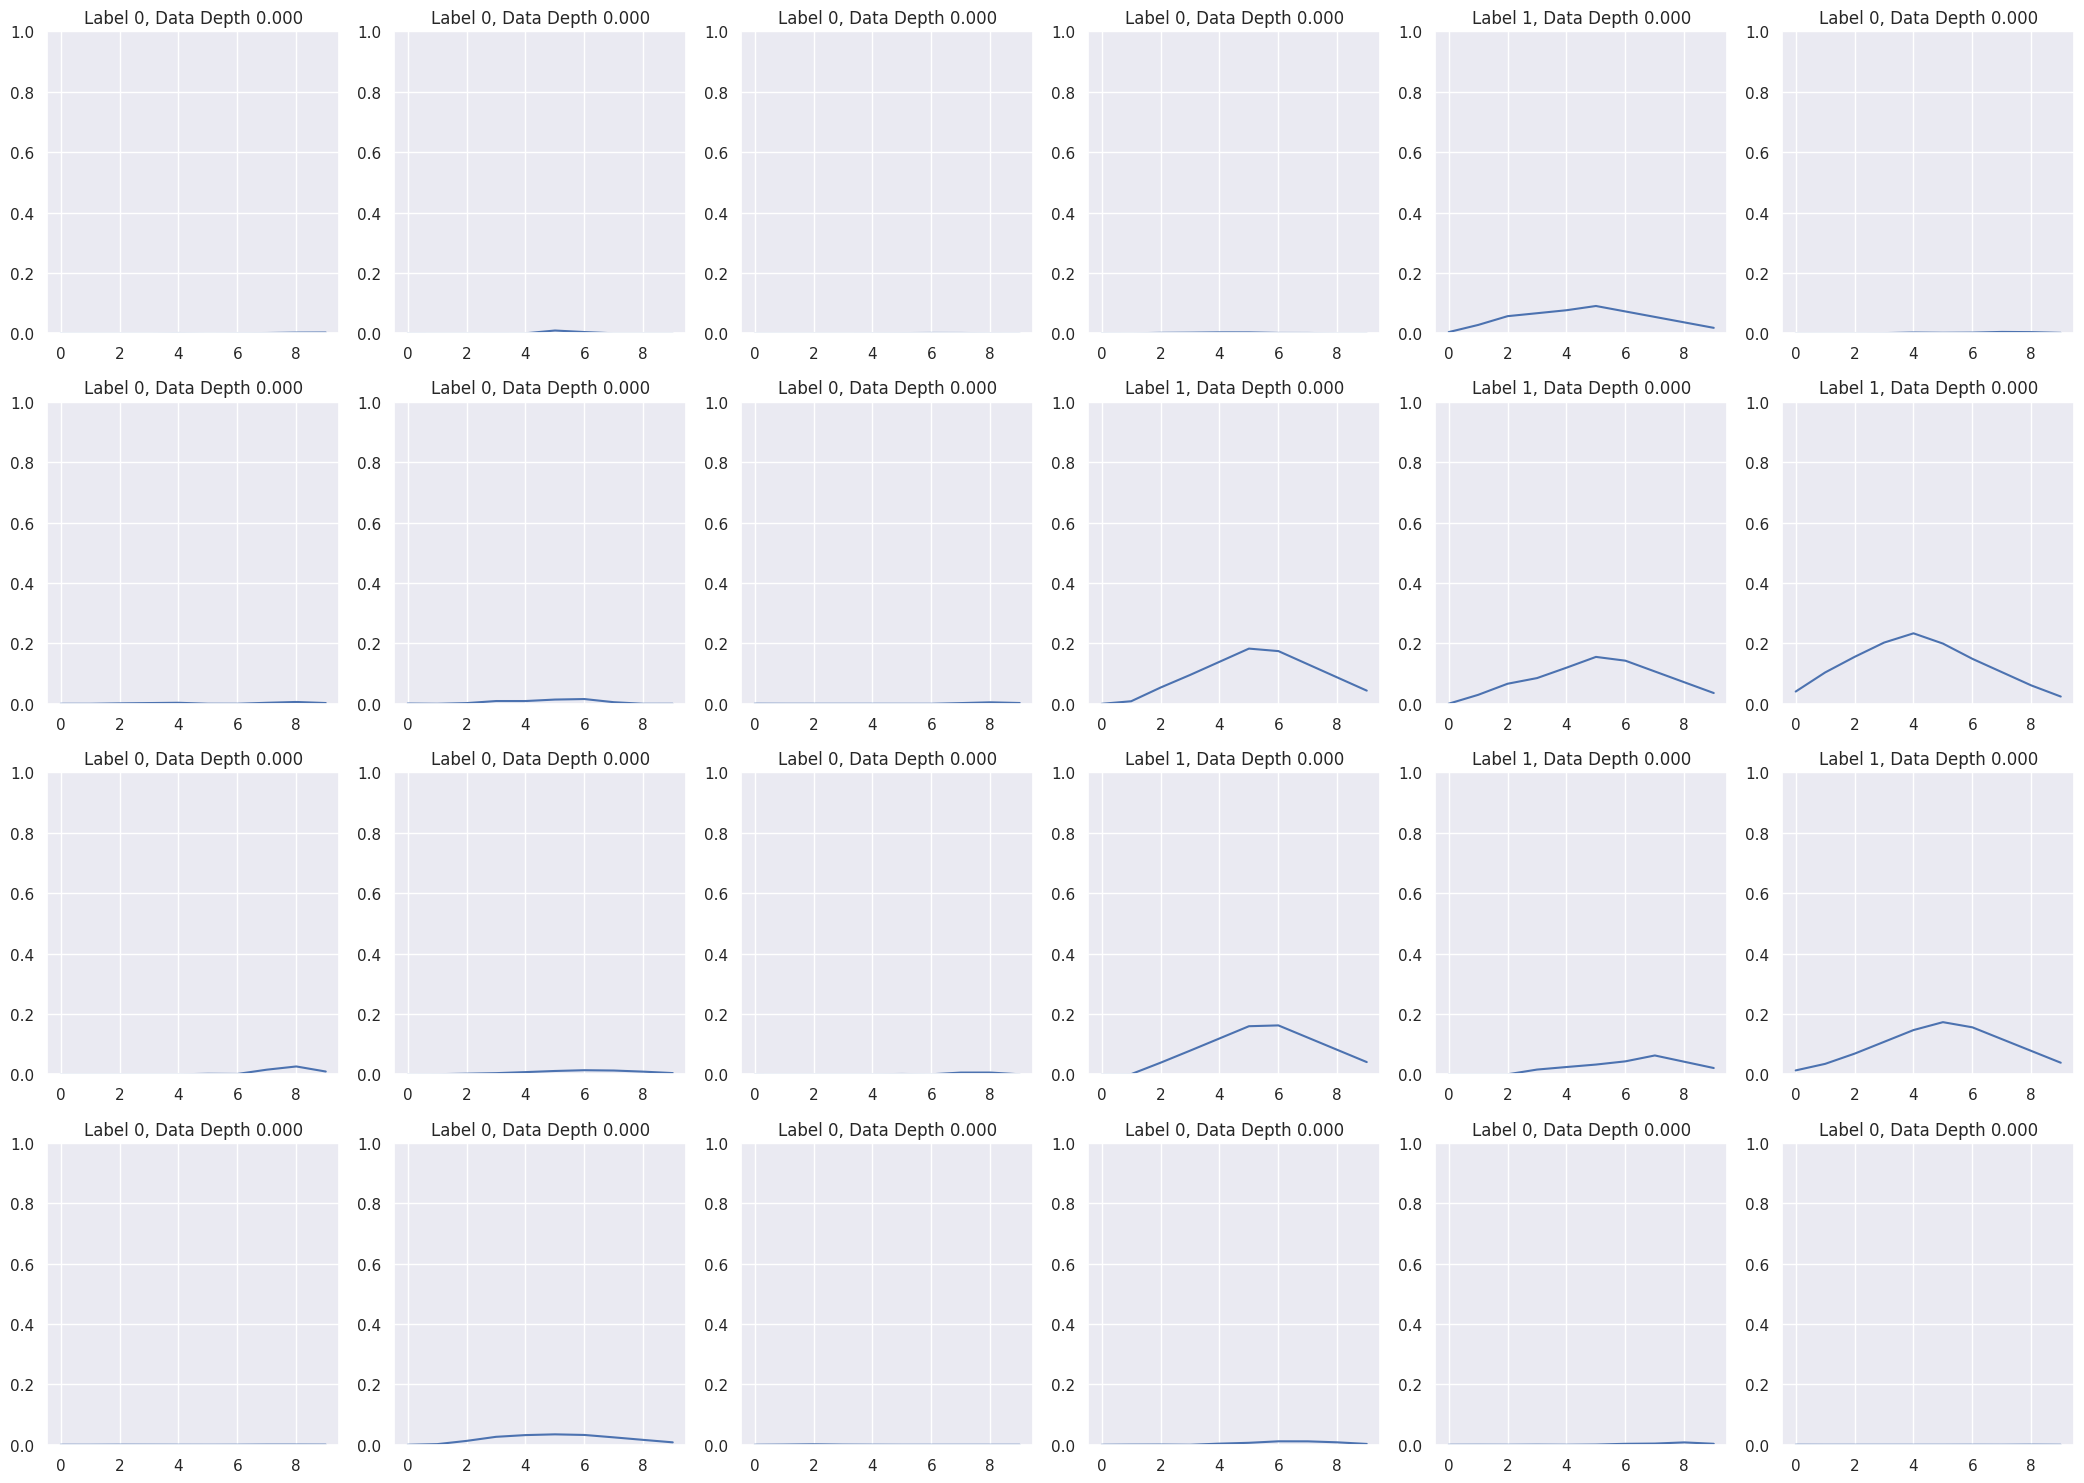

In [ ]:
plt.clf()
# Convex Hull Peeling
temp_list = convex_hull_peeling(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
CHPDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], CHPDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

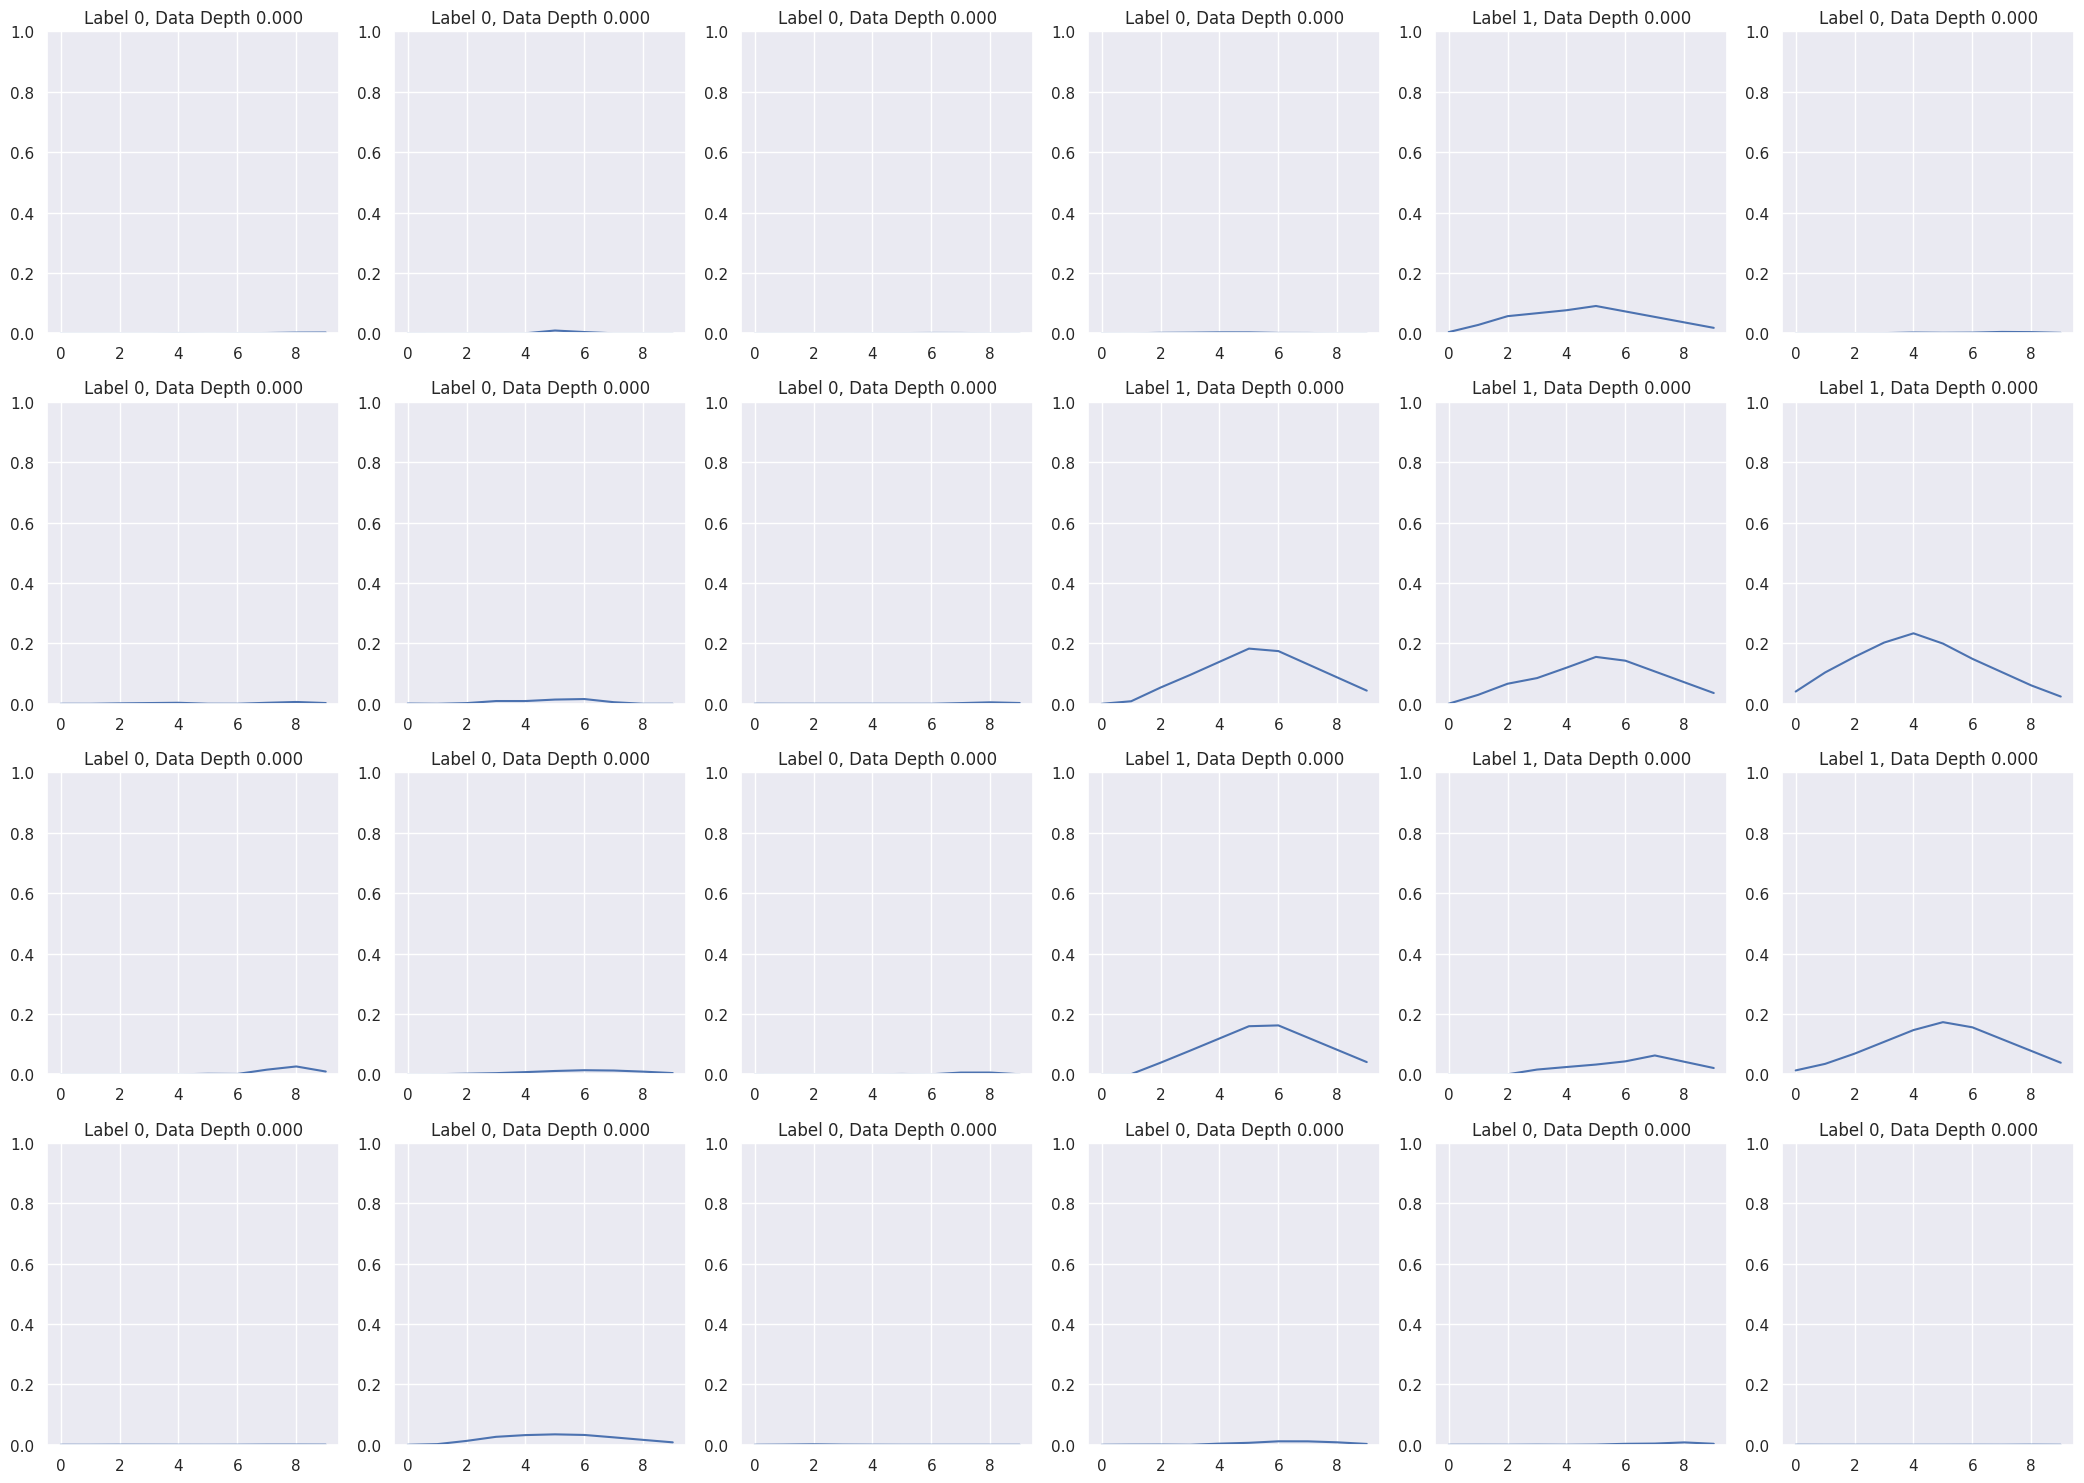

In [ ]:
#Zoinoid
temp_list = zoinoid(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
ZoinoidDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], ZoinoidDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

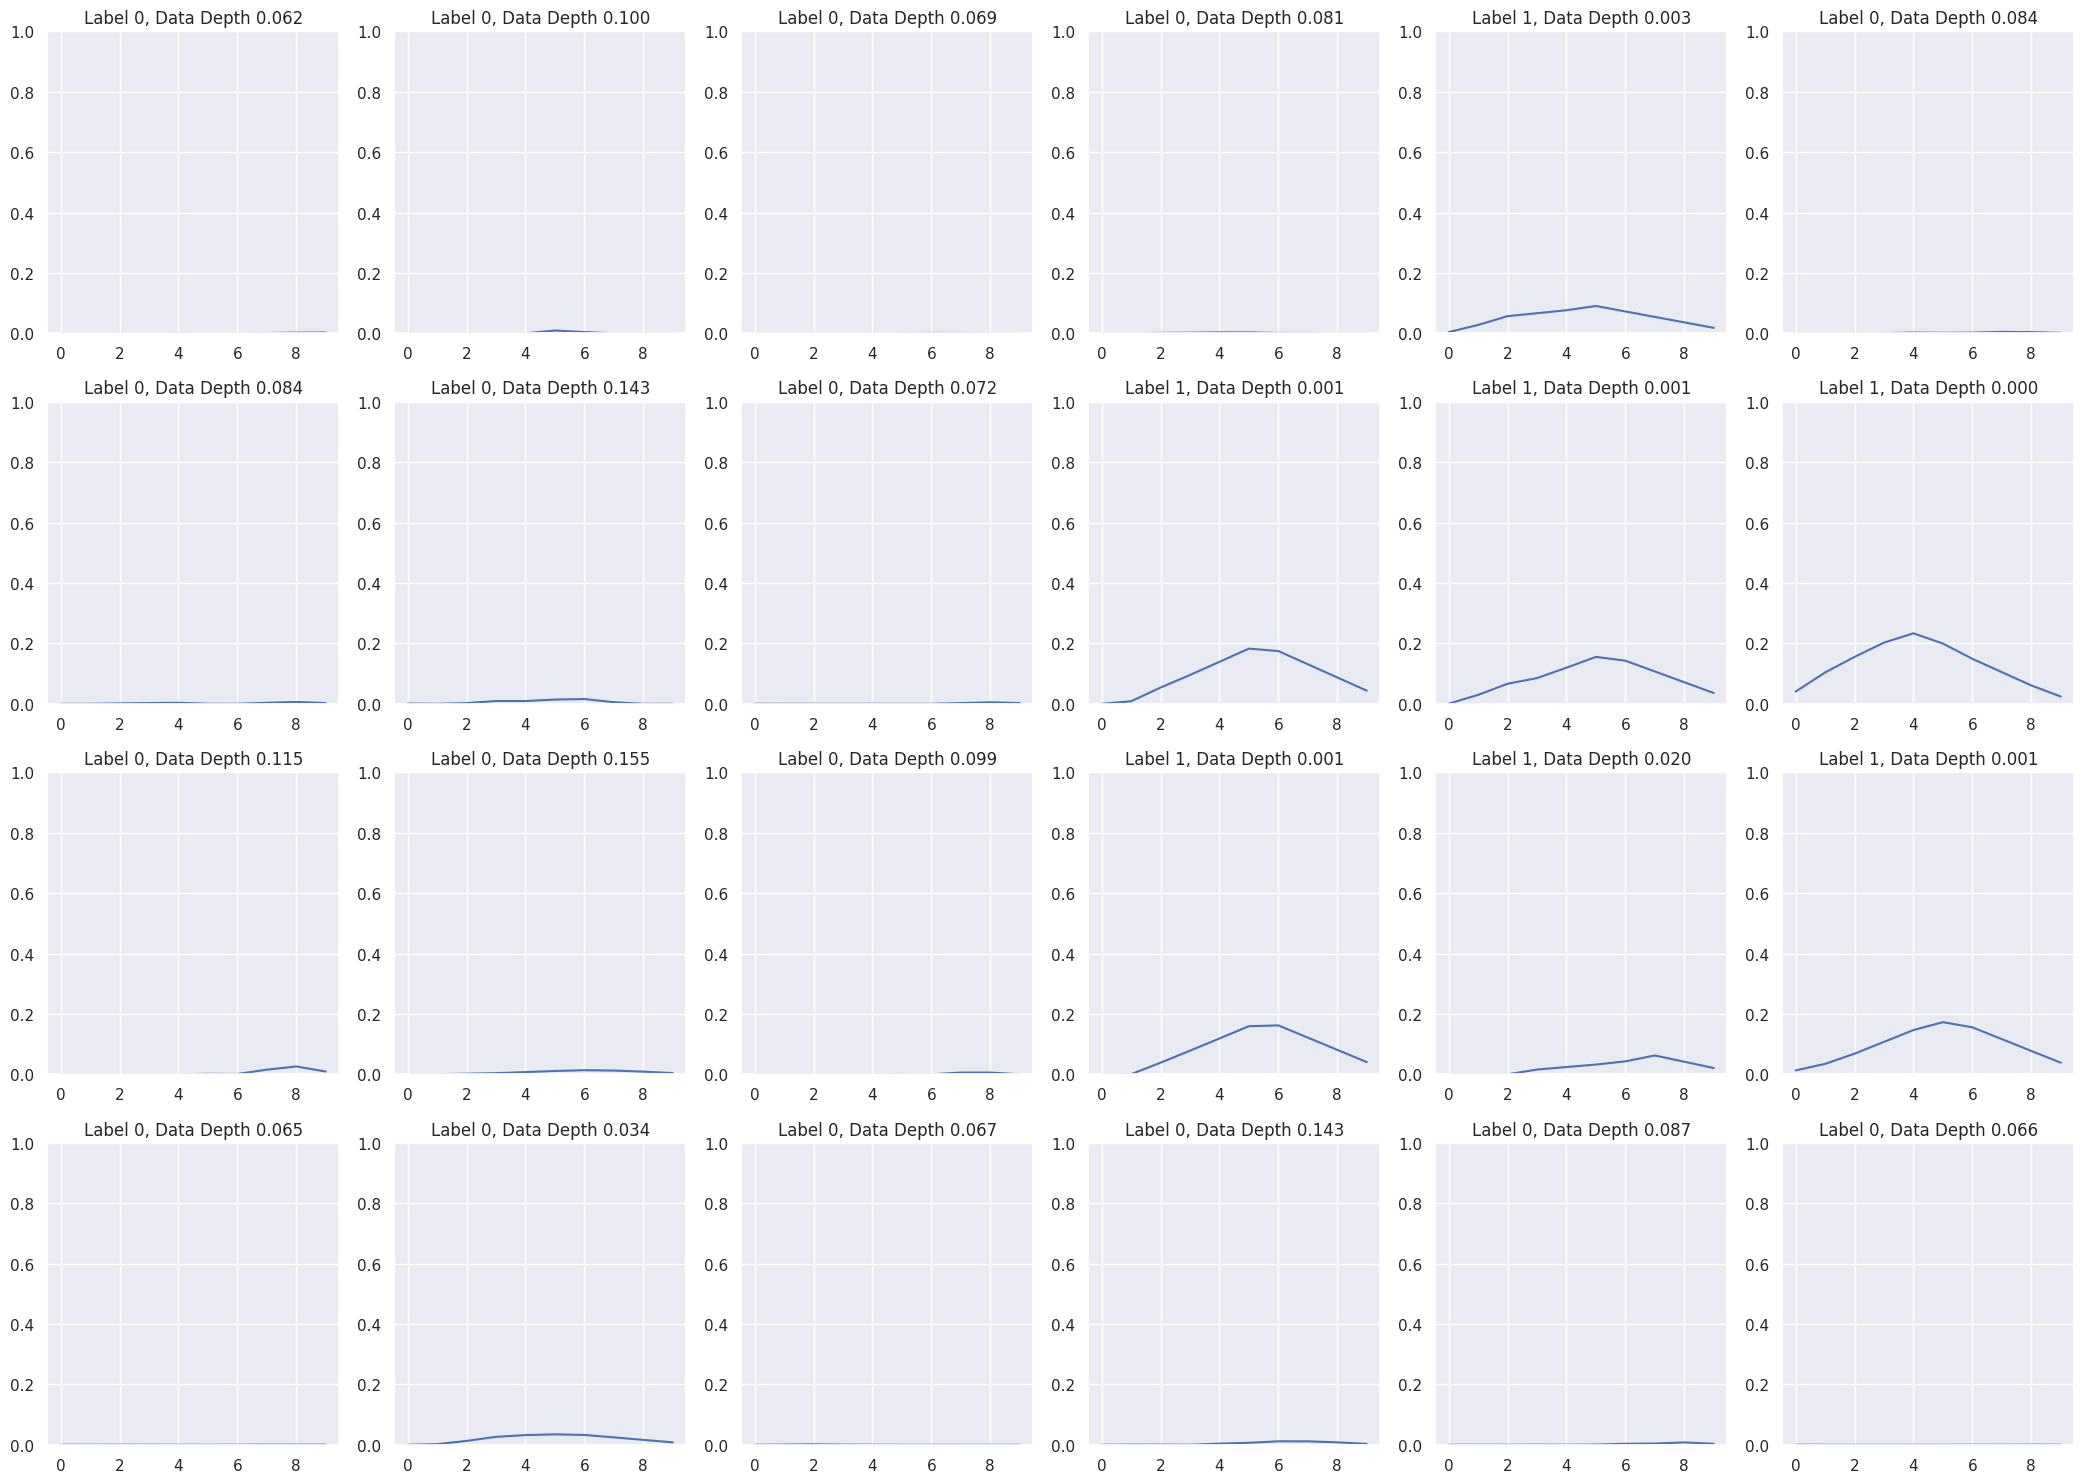

In [ ]:
#Spatial
temp_list = spatial(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
SpatialDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], SpatialDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

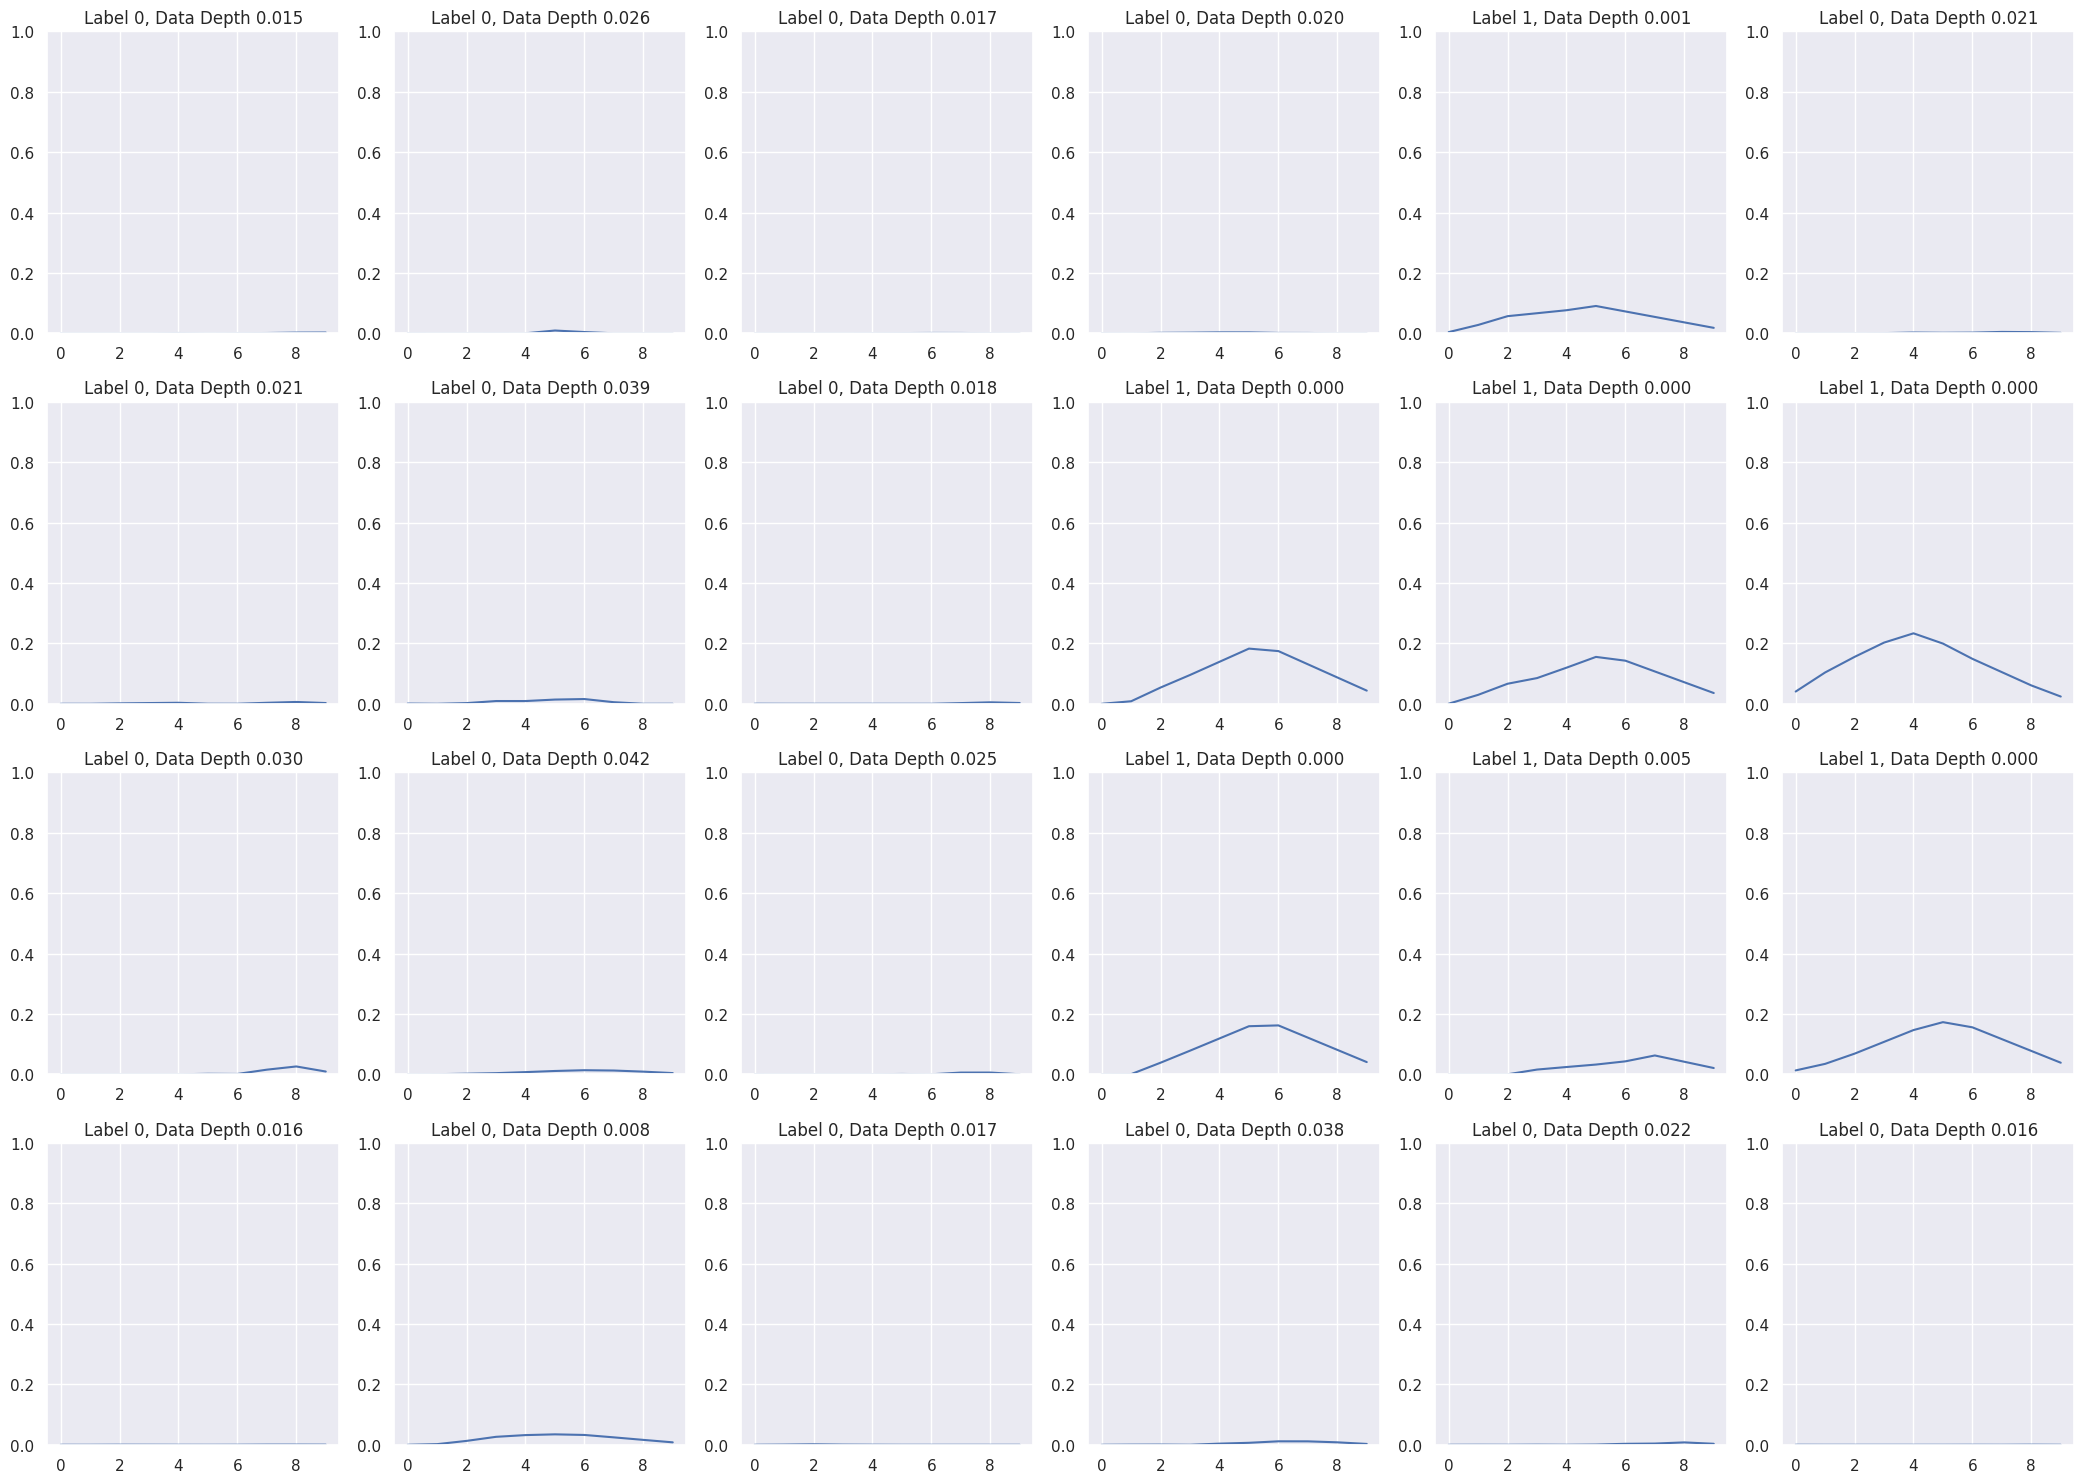

In [ ]:
#Mahalanobis
temp_list = mahalanobis(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
MahalanobisDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6+ j], MahalanobisDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

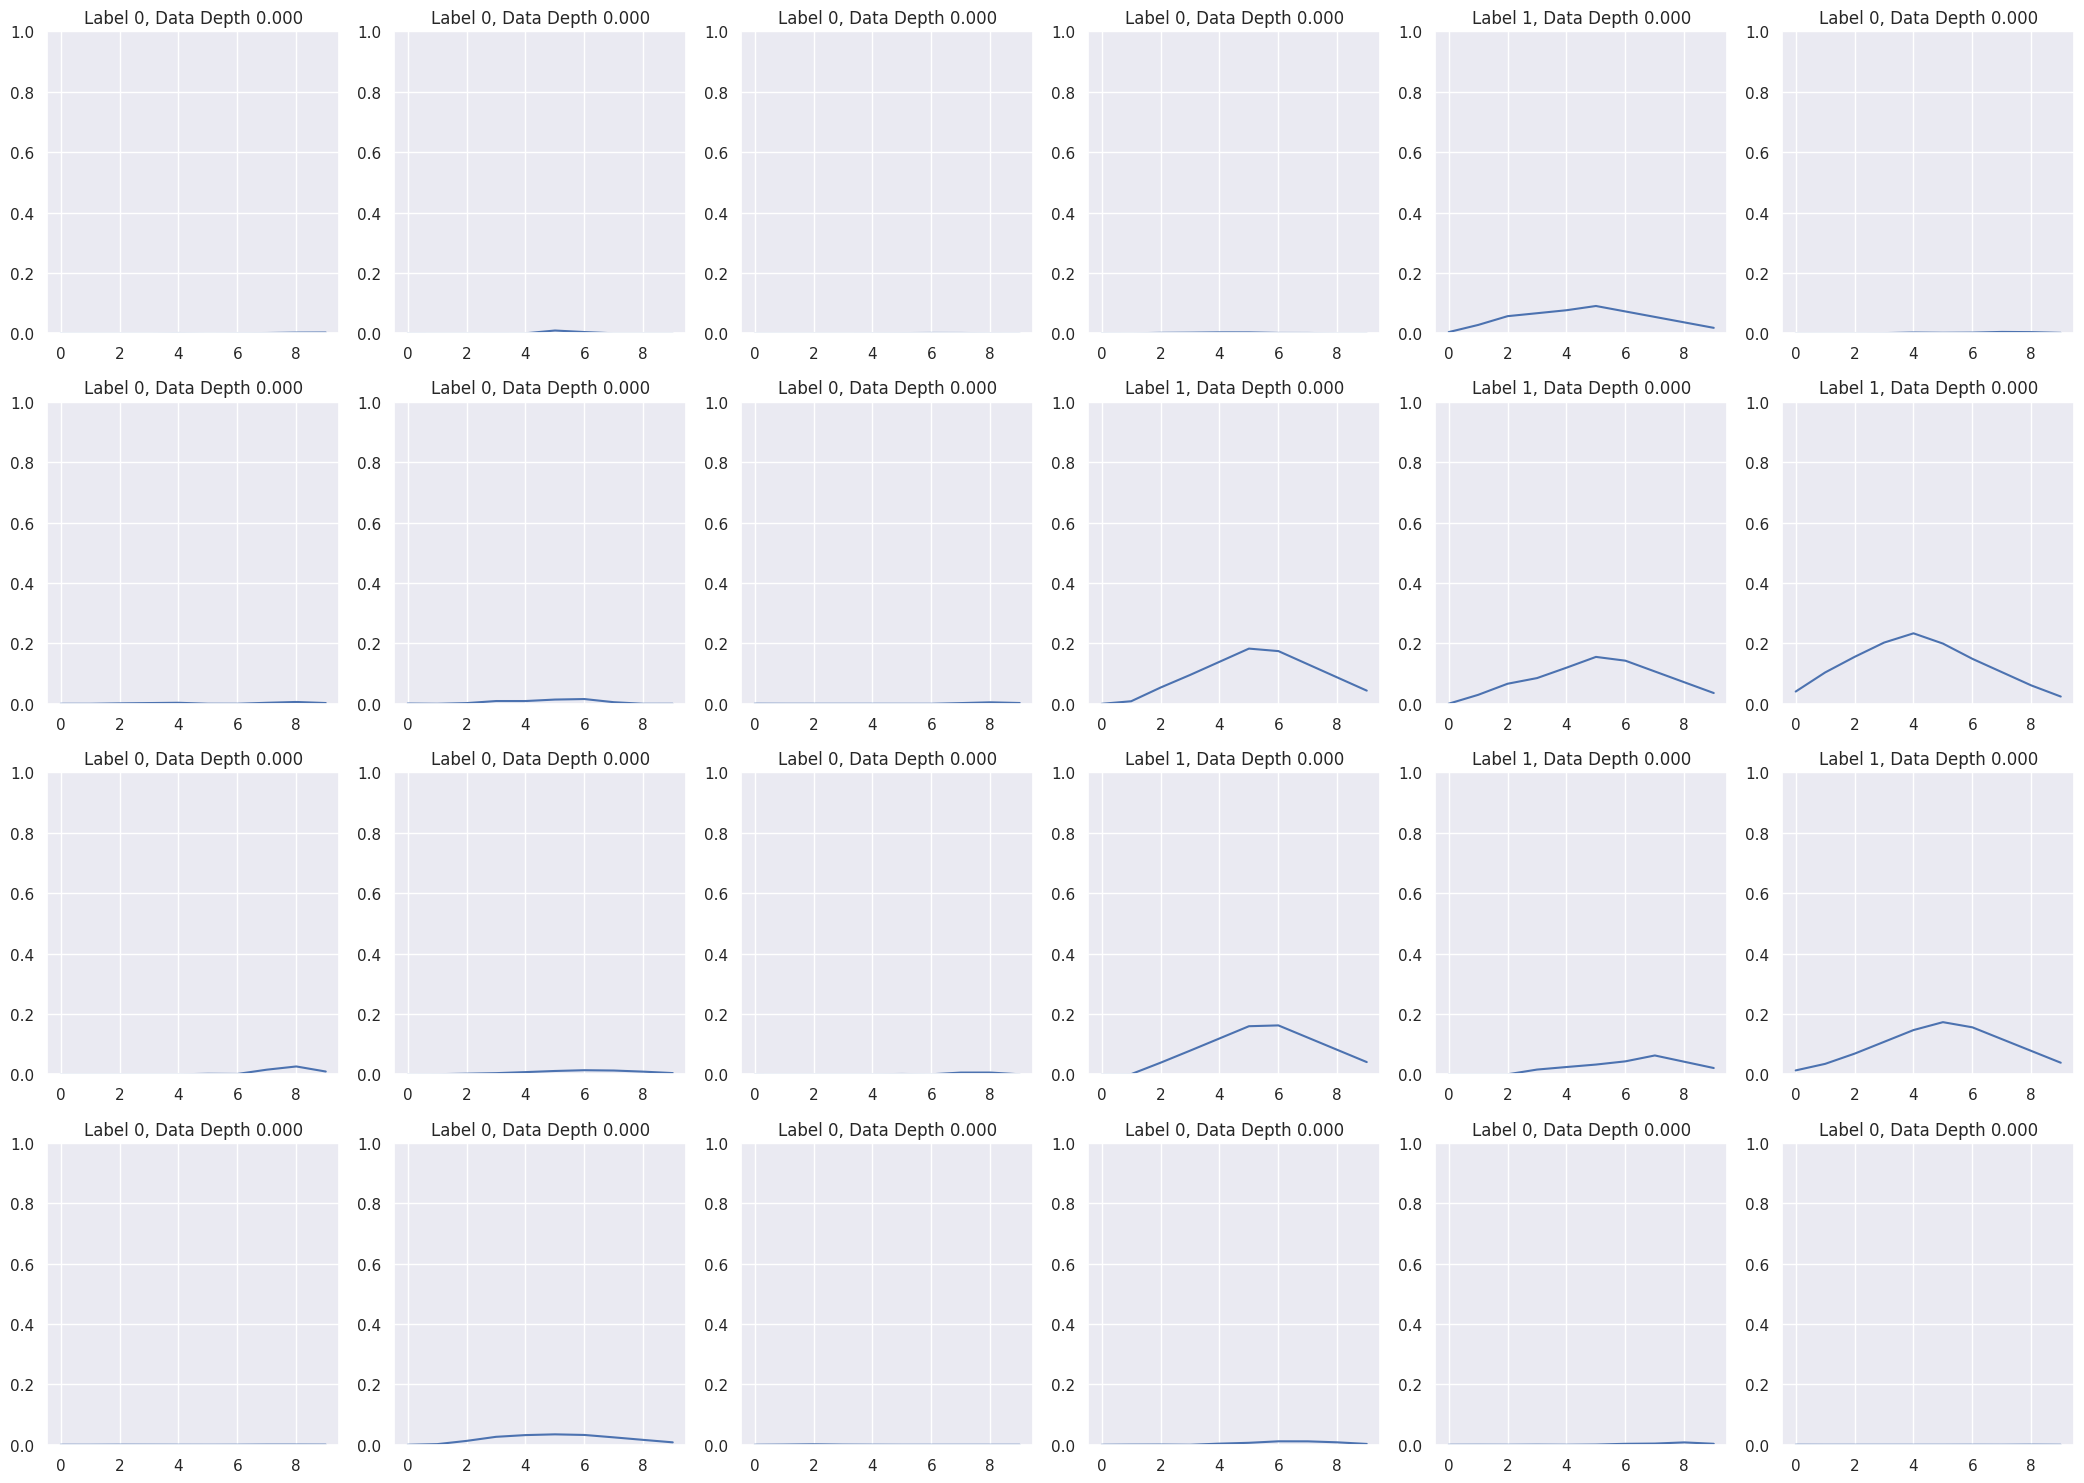

In [ ]:
#Halfspace
temp_list = halfspace(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
HalfspaceDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], HalfspaceDepthList[i*6 + j]))

plt.tight_layout()
plt.show()


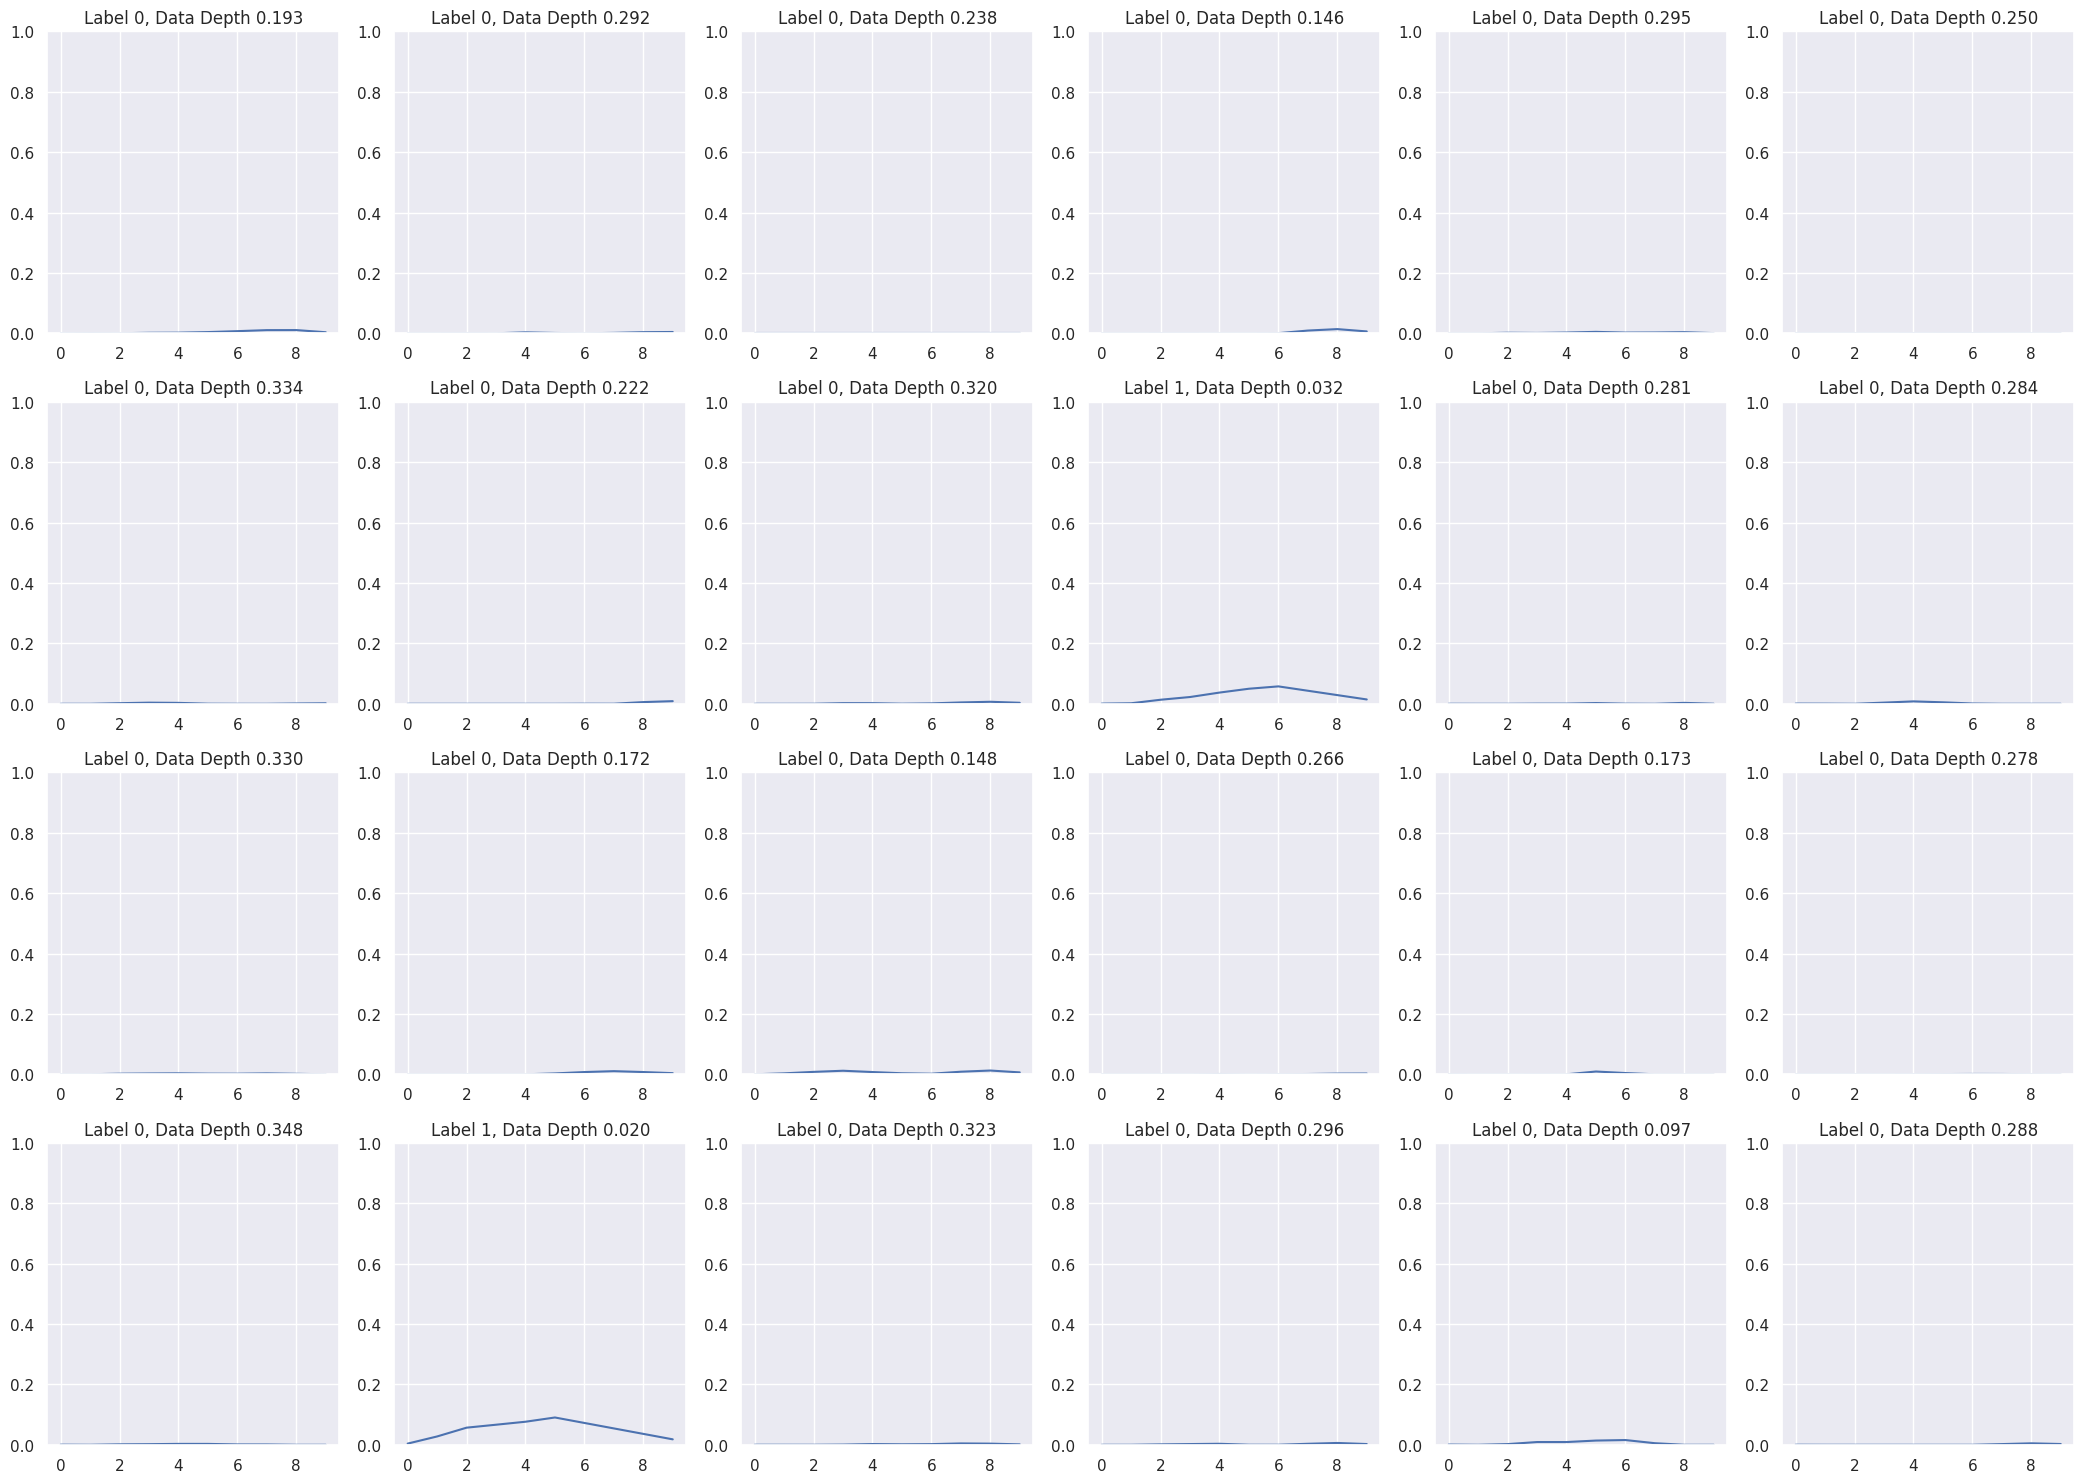

In [ ]:
#Projection
temp_list = projection(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
ProjectionDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6+ j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], ProjectionDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

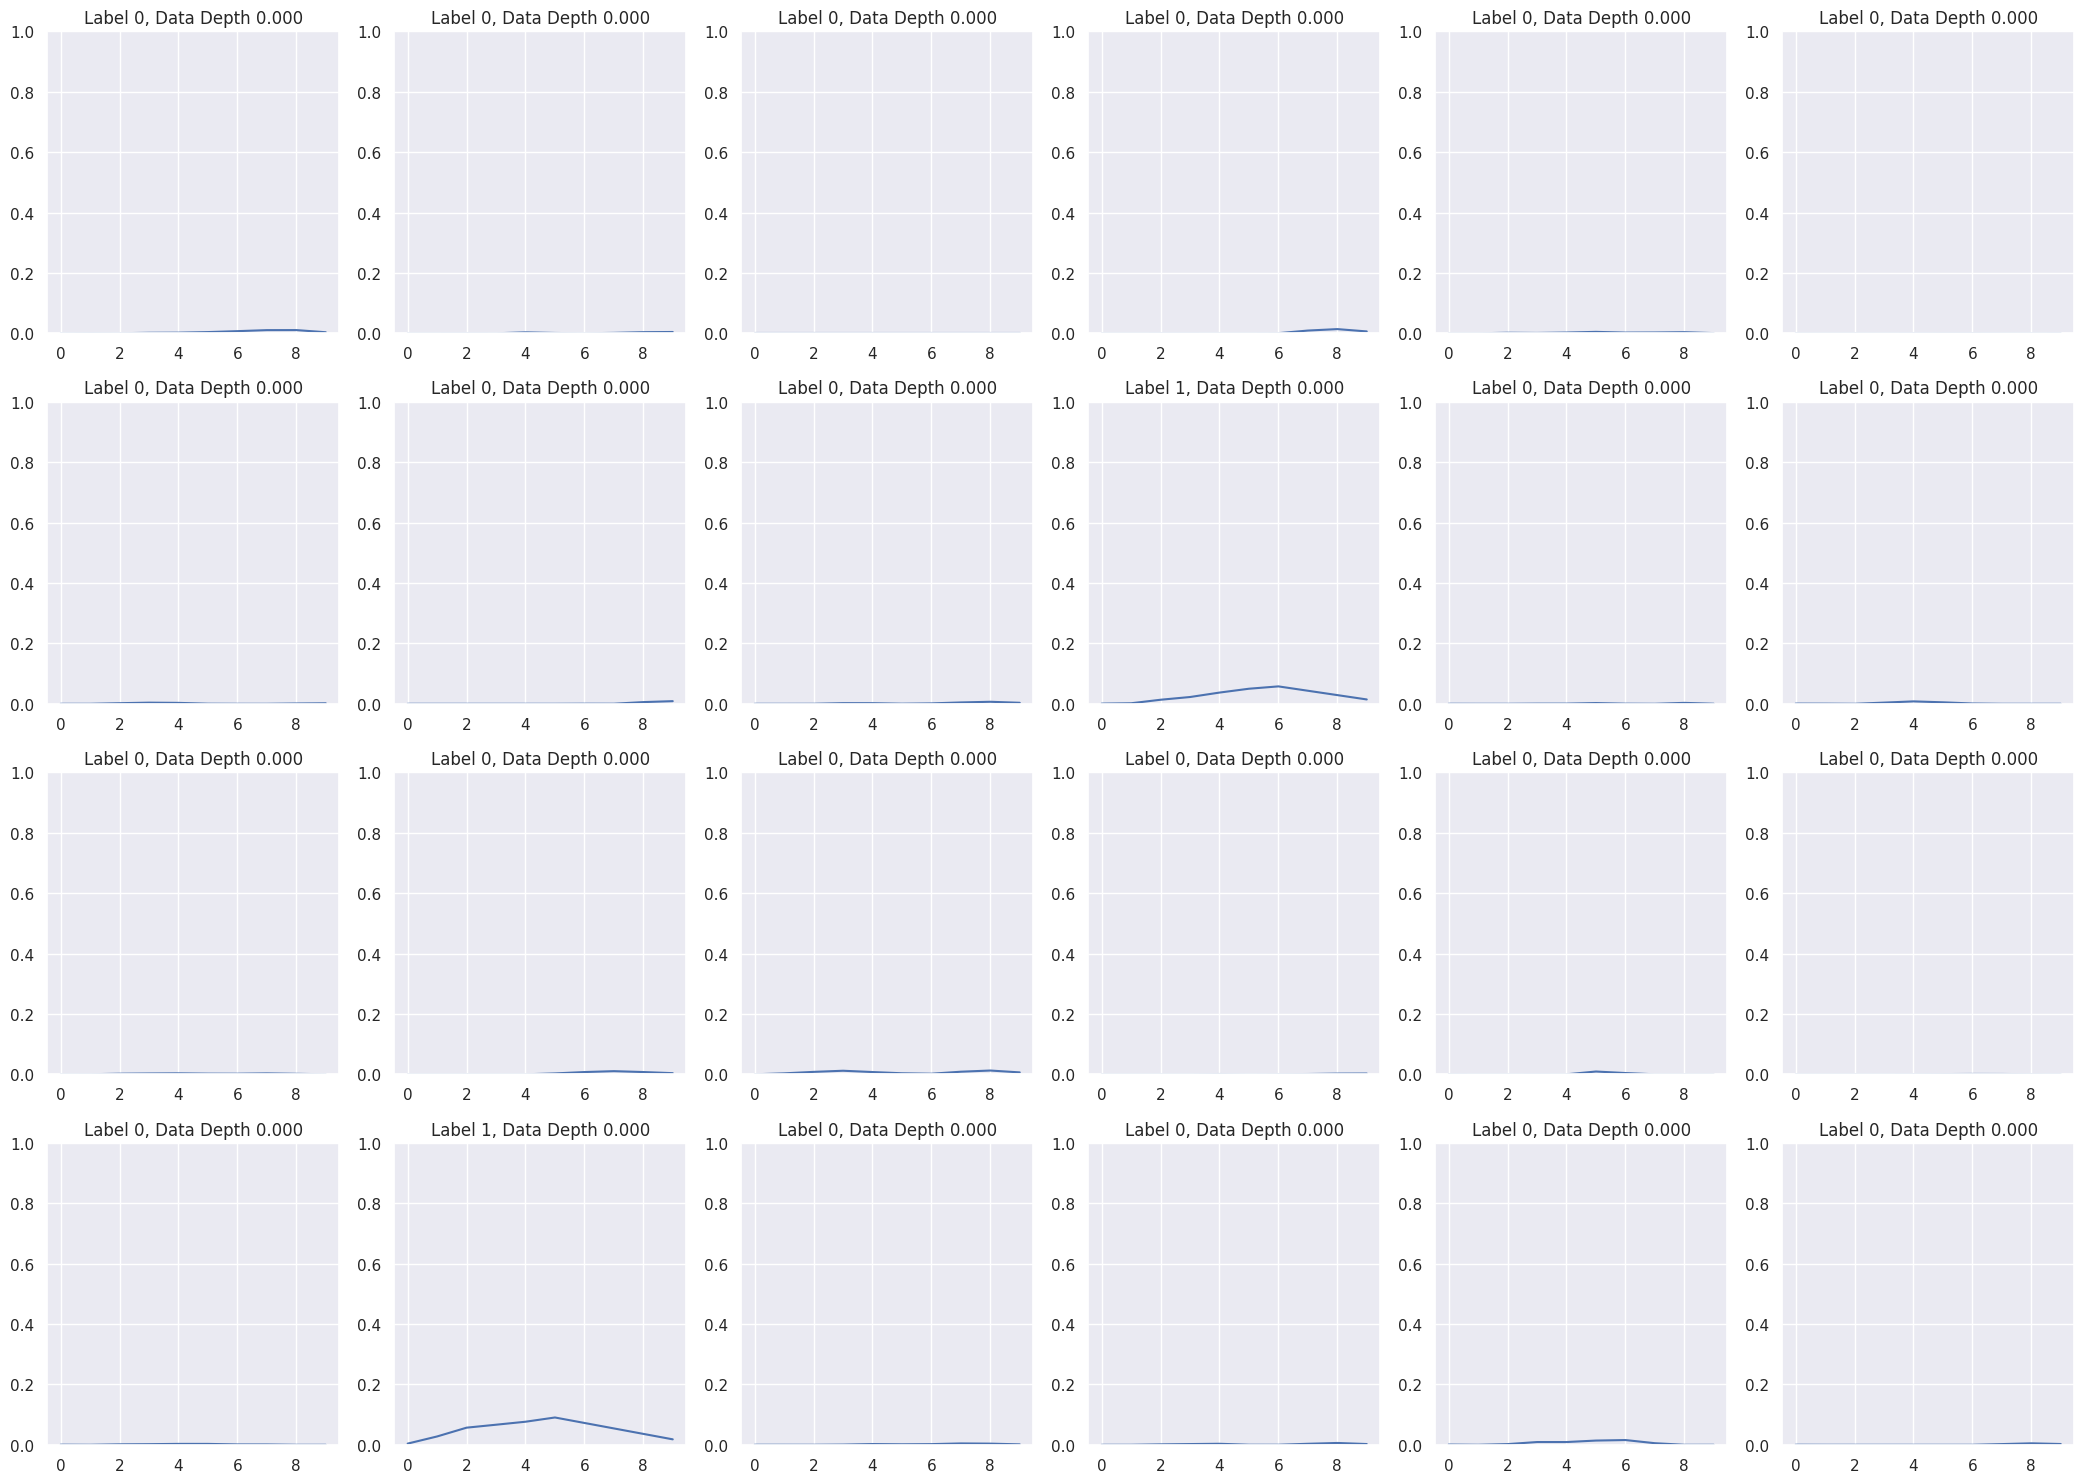

In [ ]:
#Simplicial
temp_list = simplicial(m)
list_r = []
for i in temp_list:
  list_r.append(i[0])
SimplicialDepthList = list_r
fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        if i* 6 + j <= 24:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], SimplicialDepthList[i*6 + j]))

plt.tight_layout()
plt.show()

24


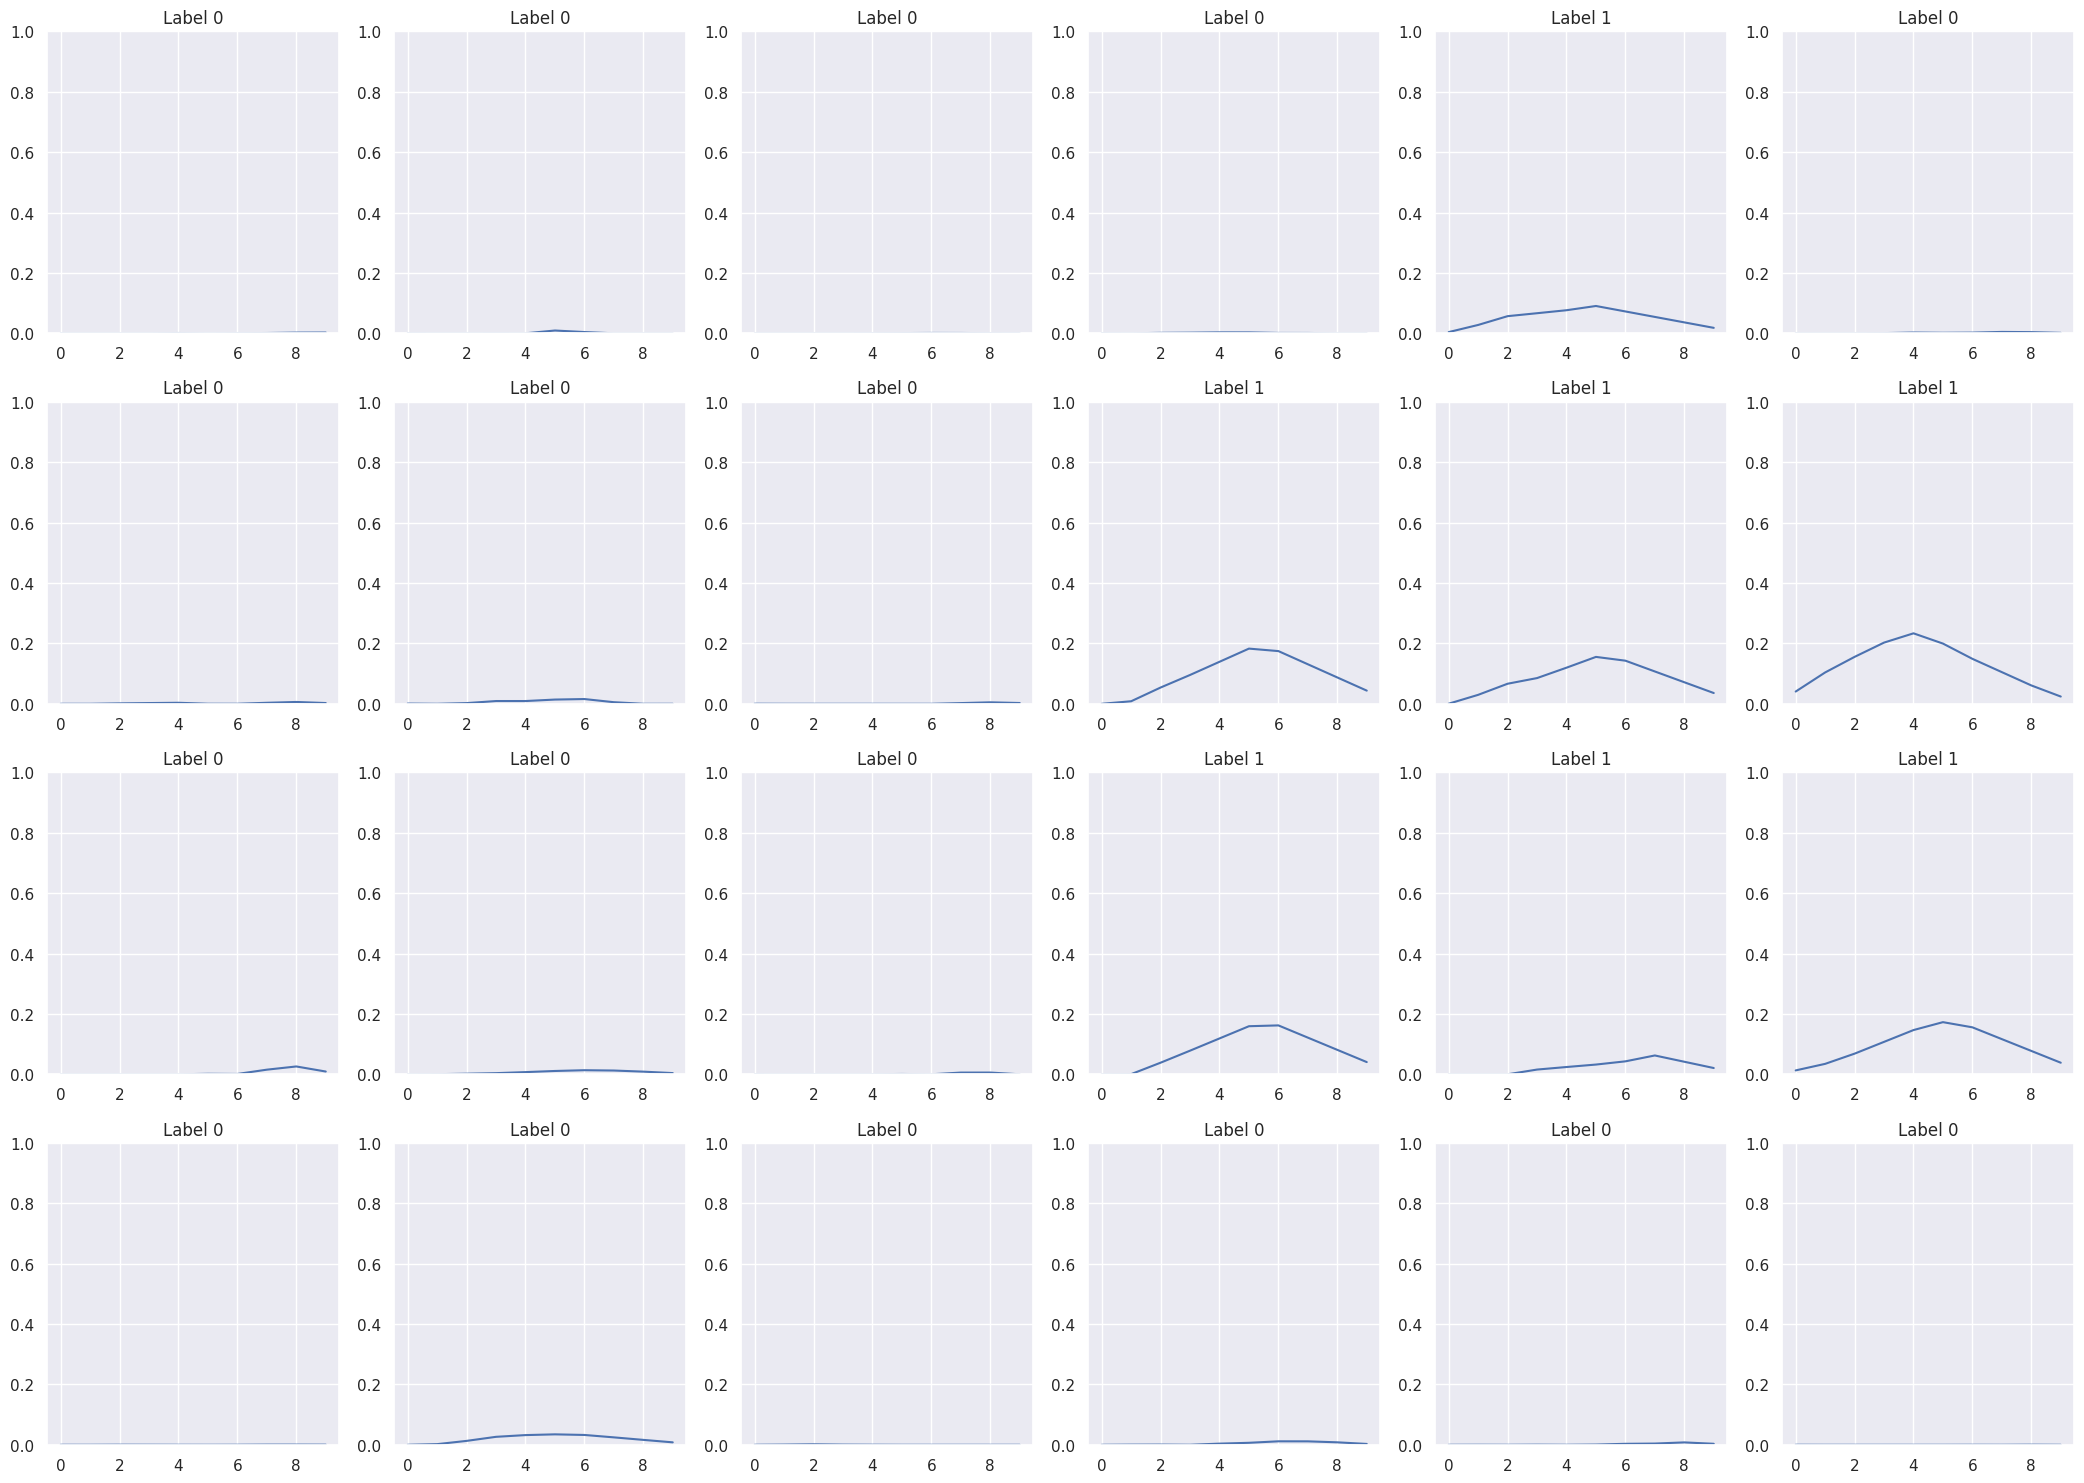

In [ ]:
# Vectorize the PDs then do cluster
# Vectorize by Silhoutte
SilList = PD2Silhoutte(PDList, resolution=10)

print (len(SilList))

# Result from R
# simplexVolDepthList = [0.9782665, 0.9598752, 0.9803188, 0.9715499, 0.979676, 0.968288, 0.954594, 0.4730382, 0.9818818, 0.6771605, 0.9807952, 0.9813164, 0.9812129, 0.9795362, 0.9805354, 0.9723188, 0.962765, 0.000]

fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        axs[i, j].plot(SilList[i*6 + j])
        axs[i, j].set_ylim(0, 1)

        #axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], simplexVolDepthList[i*6 + j])) # Add later with data depth value
        axs[i, j].title.set_text('Label {}'.format(groundTruth[i*6 + j]))

plt.tight_layout()
plt.show()